## Locating unassembled centromeres in stickleback genome assembly

The centromeres on many chromosomes can't be located using other approaches, likely because they are not in the genome assembly. So here we will attemp to locate the missing centromeres by making use of alignments of linked reads. The proceedure was as follows:

1. We identified the centromere repeat using ?????
2. We aligned this repeat to the genome assembly using blastn. Most of these hits were in unplaced scaffolds. 
3. We then aligned the HiC data used for assembly back to the assembly itself. Including the autosomes, X, Y and all unplaced scaffolds. 
4. Below, we search for read pairs with one mate aligning to a chromosome scaffold, and the other mapping to one of the unplaced scaffolds known to contain the centromere repeat. 
5. We then calculate the proportion of reads in each bin in a chromosome with mates hitting an unplaced centromere scaffold. The location of these reads should show us roughly where the centromere is. 


In [1]:
def get_mate_hit_counts(bamfile_path, scaffs, chrom):
    
    """
    Counts the number of read pairs with one mate aligning to <chrom> and one aligning to a scaffold in <scaffs>
    
    bamfile_path     -    Full path to bam file (str)
    scaffs           -    List of scaffold names to check for mates (list or tuple)
    chrom            -    Name of the chromosome to fetch reads from
    
    Returns list of all read start positions on <chrom> and a list of the start positions of <chrom> reads with a mate aligning to a scaffold in <scaffs>
    
    """
    
    import pysam
    import numpy as np
    
    read_count = 0
    scaff_hit_count = 0

    read_positions = []
    scaff_hit_positions = []

    
    bamfile = pysam.AlignmentFile(bamfile_path, 'rb')
    
    for read in bamfile.fetch(chrom):

        if read.mate_is_mapped:

            read_count += 1
            read_positions.append(read.reference_start)

            if all(["chr" in read.reference_name, read.next_reference_name in cent_scaffs]):

                scaff_hit_positions.append(read.reference_start)
                scaff_hit_count += 1

            elif all(["chr" in read.next_reference_name, read.reference_name in cent_scaffs]):

                scaff_hit_positions.append(read.next_reference_start)
                scaff_hit_count += 1


    print("Chromosome: %s, N reads: %s, N centromere mates: %s (%s%%)" % (chrom, read_count, scaff_hit_count, np.round((scaff_hit_count/read_count),3)))
    
    return read_positions, scaff_hit_positions

In [197]:
np.ceil(max_POS/bin_size)

366.0

In [2]:
def proportion_mate_hits(read_positions, scaff_hit_positions, bin_size = 100000):
    
    """
    Calculates the proportion of reads in each bin which have a mate which hits the target scaffolds
    
    Takes read positions and scaff hit positions from above function. 
    
    """

    import numpy as np
    import math

    bin_size = bin_size
    max_POS = max(read_positions)
    N_bins = int(np.round(max_POS/bin_size, 0))

    START = 0
    bins = {}

    for i in range(N_bins+1):
        bins[((START, (START+bin_size)))] = {}
        bins[((START, (START+bin_size)))]["reads"] = 0
        bins[((START, (START+bin_size)))]["hits"] = 0

        START += bin_size


    for read_start in read_positions:  ## for all reads

        read_floor = int(bin_size * np.floor(read_start/bin_size))  ## get nearest bin boundary below
        read_ceil = int(bin_size * np.ceil(read_start/bin_size))  ## get nearest bin boundary above

        if read_floor != read_ceil:  ## if the read starts on a bin boundary it causes issue, so just ignore these few reads

            if (read_floor, read_ceil) not in bins:
                print(max(scaff_hit_positions), START, START+bin_size)
                
            bins[(read_floor, read_ceil)]["reads"] += 1


    for read_start in scaff_hit_positions:  ## for reads which hit 

        read_floor = int(bin_size * np.floor(read_start/bin_size))
        read_ceil = int(bin_size * np.ceil(read_start/bin_size))

        if read_floor != read_ceil:
            
            if (read_floor, read_ceil) not in bins:
                print(max(scaff_hit_positions), START, START+bin_size)

            bins[(read_floor, read_ceil)]["hits"] += 1
            
    read_proportions = []
    bin_starts = []

    for i in bins:
        if bins[i]["reads"] > 0:
            read_proportions.append(bins[i]["hits"]/bins[i]["reads"])
            bin_starts.append(i[0])
        
    return read_proportions, bin_starts

In [3]:
## Unplaced scaffolds with centromere hits

cent_scaffs = ["HiC_scaffold_124", 
               "HiC_scaffold_138",
               "HiC_scaffold_144",
               "HiC_scaffold_160",
               "HiC_scaffold_162",
               "HiC_scaffold_163",
               "HiC_scaffold_170",
               "HiC_scaffold_190",
               "HiC_scaffold_202",
               "HiC_scaffold_209",
               "HiC_scaffold_226",
               "HiC_scaffold_228",
               "HiC_scaffold_232",
               "HiC_scaffold_250",
               "HiC_scaffold_26",
               "HiC_scaffold_28",
               "HiC_scaffold_323",
               "HiC_scaffold_349",
               "HiC_scaffold_35",
               "HiC_scaffold_37",
               "HiC_scaffold_38",
               "HiC_scaffold_39",
               "HiC_scaffold_400",
               "HiC_scaffold_444",
               "HiC_scaffold_457",
               "HiC_scaffold_46",
               "HiC_scaffold_48",
               "HiC_scaffold_60",
               "HiC_scaffold_67",
               "HiC_scaffold_69",
               "HiC_scaffold_70",
               "HiC_scaffold_75",
               "HiC_scaffold_76",
               "HiC_scaffold_84",
               "HiC_scaffold_86"]

# **NOTE - this takes a while, don't re-run unless needed. Results are output below. 

In [224]:
bam_path = "/Users/dj20y461/Data_temp/Stickleback/Y_comp/centromeres/bam/HiC_aligned_sorted.bam"
chromosomes = ["chr1", "chr2", "chr3", "chr4", "chr5","chr6", "chr7", "chr8", "chr9", "chr10", "chr11", "chr12", "chr13", "chr14", "chr15", "chr16", "chr17", "chr18", "chr19", "chr20", "chr21"]
binsize = 100000

chrom_dict = {}

for chrom in chromosomes:

    print("Processing %s" % chrom)
    
    chrom_dict[chrom] = {}

    ## get read and mate hit positions
    read_poss, cent_hits = get_mate_hit_counts(bam_path, cent_scaffs, chrom)

    ## calculate bin proportions
    chrom_dict[chrom]["y"], chrom_dict[chrom]["x"] = proportion_mate_hits(read_poss, cent_hits, bin_size = 100000)
    
    print("%s done!" % chrom)



Processing chr6
Chromosome: chr6, N reads: 28031029, N centromere mates: 24916 (0.001%)
chr6 done!
Processing chr7
Chromosome: chr7, N reads: 46561388, N centromere mates: 46292 (0.001%)
chr7 done!
Processing chr8
Chromosome: chr8, N reads: 30095253, N centromere mates: 24991 (0.001%)
chr8 done!
Processing chr9
Chromosome: chr9, N reads: 30733920, N centromere mates: 26132 (0.001%)
chr9 done!
Processing chr10
Chromosome: chr10, N reads: 24163071, N centromere mates: 22170 (0.001%)
chr10 done!
Processing chr11
Chromosome: chr11, N reads: 25126964, N centromere mates: 26533 (0.001%)
chr11 done!
Processing chr12
Chromosome: chr12, N reads: 18581154, N centromere mates: 55580 (0.003%)
chr12 done!
Processing chr13
Chromosome: chr13, N reads: 43136985, N centromere mates: 33042 (0.001%)
chr13 done!
Processing chr14
Chromosome: chr14, N reads: 24380523, N centromere mates: 23530 (0.001%)
chr14 done!
Processing chr15
Chromosome: chr15, N reads: 26240145, N centromere mates: 24283 (0.001%)
chr1

In [233]:
with open("/Users/dj20y461/Data_temp/Stickleback/Y_comp/centromeres/cent_mate_hit_proportions.txt", 'w') as cent_hits_out:
    for chrom in chrom_dict:
        for i in range(len(chrom_dict[chrom]["x"])):
            cent_hits_out.write("%s\t%s\t%s\n" % (chrom, chrom_dict[chrom]["x"][i], chrom_dict[chrom]["y"][i]))
        



## Matching this with centromere monomer mappings and Pi along the genome

Pi was calculated using the 4 females only, so that Chr12 and Chr19 can be included. 

In [4]:
auto_pi = {}
all_pi = []

with open("/Users/dj20y461/Data_temp/Stickleback/Y_comp/centromeres/Pi/Gw_Autos_X_filtered_RHB_only_MASK_Pi_kept_1_females.windowed.pi", 'r') as unfiltered_pi:
    
    header = next(unfiltered_pi)
    
    for locus in unfiltered_pi:
        if not any([locus.split()[0] == "chrXX", locus.split()[0] == "chrXX"]):
            chrom = locus.split()[0]
            
            if chrom not in auto_pi:
                auto_pi[chrom] = {}
                auto_pi[chrom]["POS"] = []
                auto_pi[chrom]["PI"] = []
                
            
            auto_pi[chrom]["POS"].append(int(locus.split()[1]))
            auto_pi[chrom]["PI"].append(float(locus.split()[4]))
            all_pi.append(float(locus.split()[4]))

In [10]:
for chrom in auto_pi:
    print(chrom, max(auto_pi[chrom]["POS"]))

chr4 41420001
chr7 36670001
chr1 36490001
chr2 27020001
chr12 24820001
chr13 24840001
chr9 24380001
chr17 23700001
chr8 23480001
chr20 23270001
chr19 23120001
chr16 22510001
chr6 21680001
chr3 20840001
chr15 20510001
chr21 19670001
chr11 19650001
chr10 19090001
chr14 19030001
chr18 18920001
chr5 18240001


In [239]:
cent_hits = {}

with open("/Users/dj20y461/Data_temp/Stickleback/Y_comp/centromeres/Gw_cent.out") as cent_positions:
    
    for line in cent_positions:
        
        chrom = line.split()[1]
        pos = int(line.split()[8])
        
        if chrom not in cent_hits:
            cent_hits[chrom] = []
            
        cent_hits[chrom].append(pos)
    

## Females only 

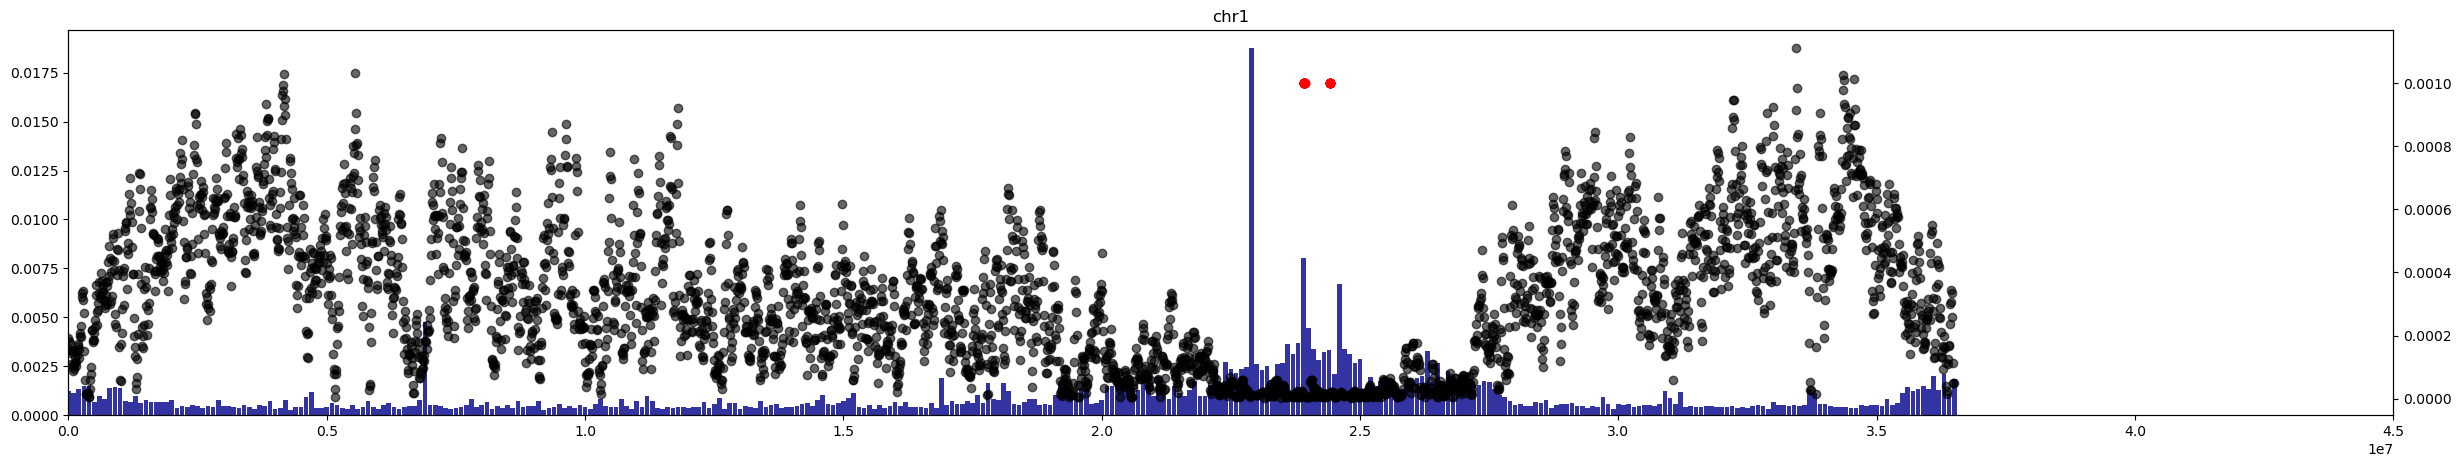

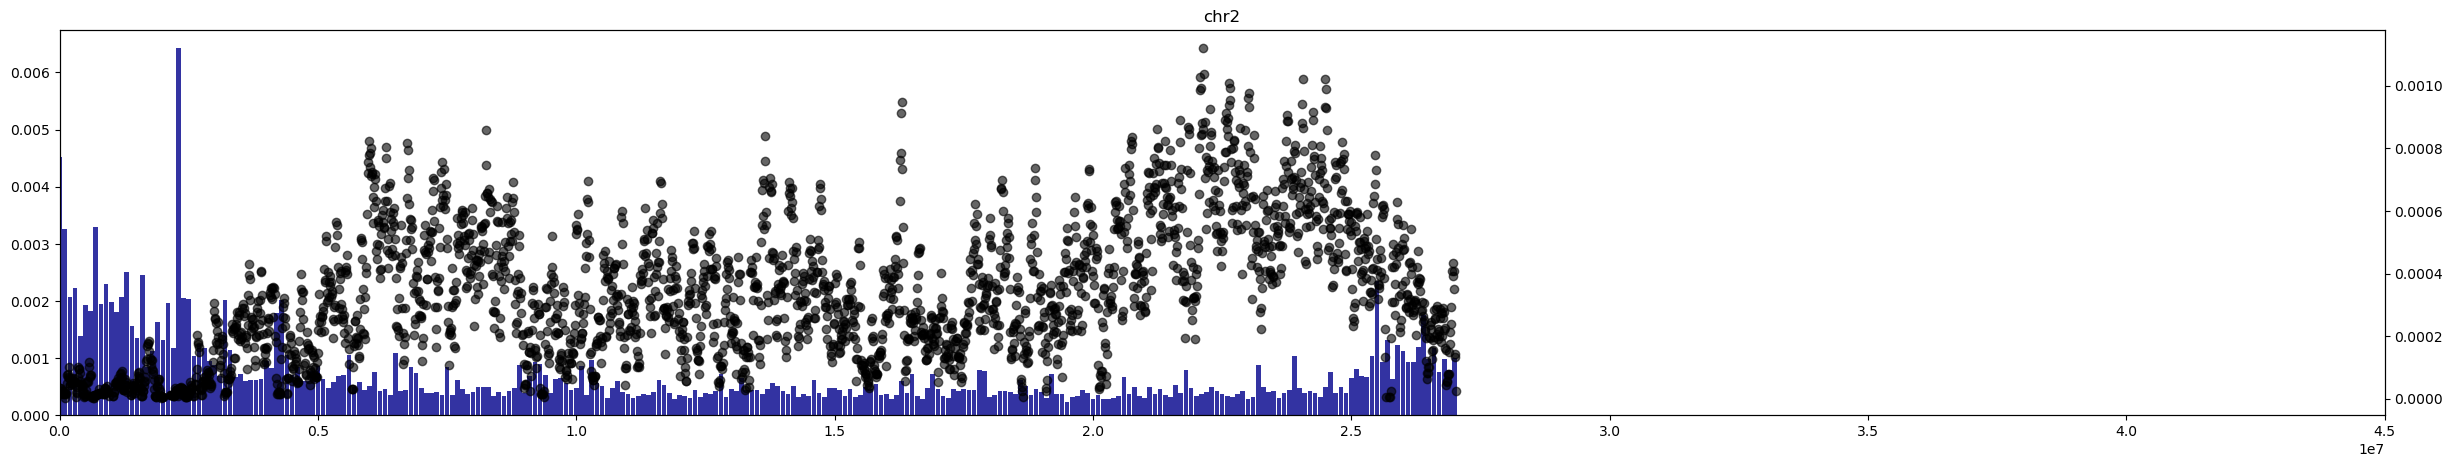

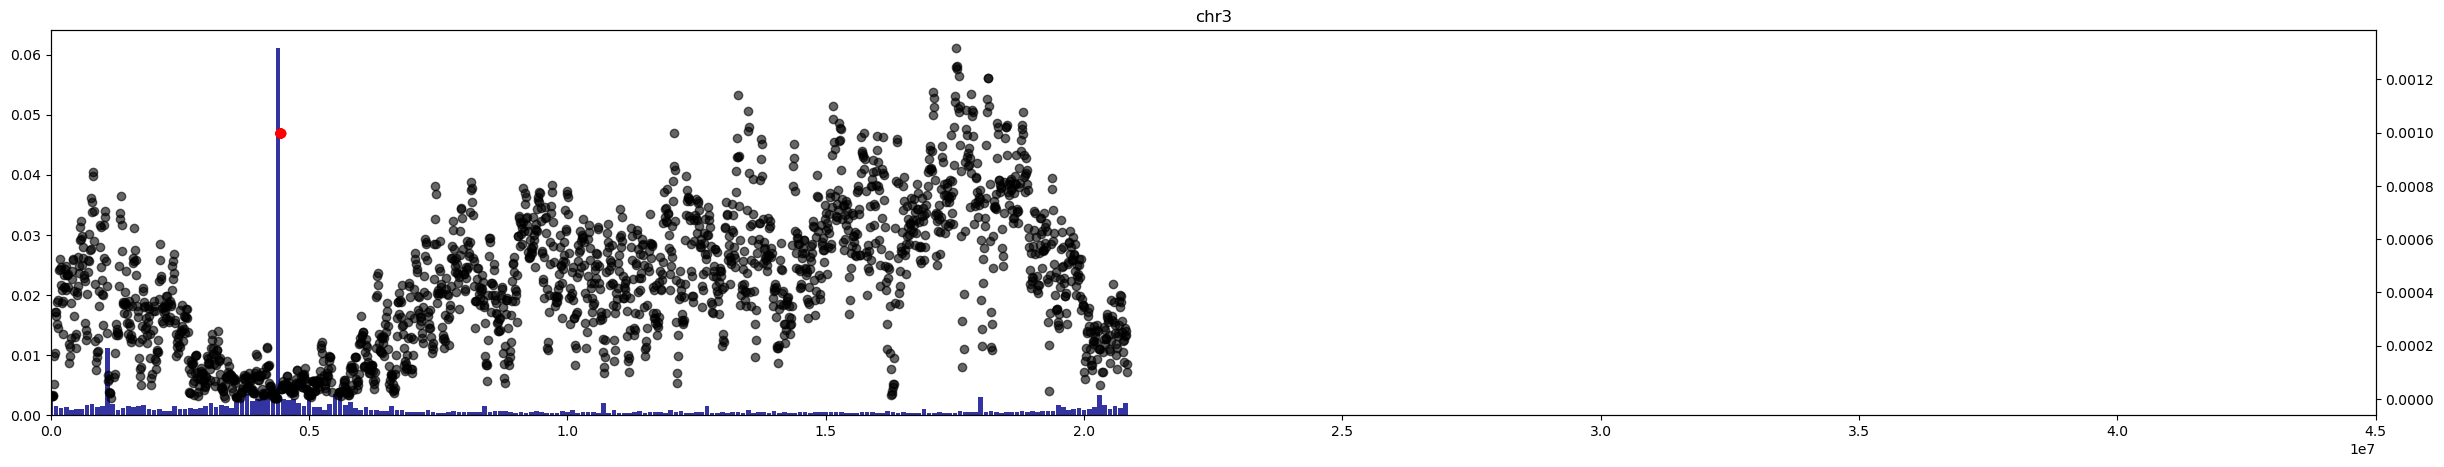

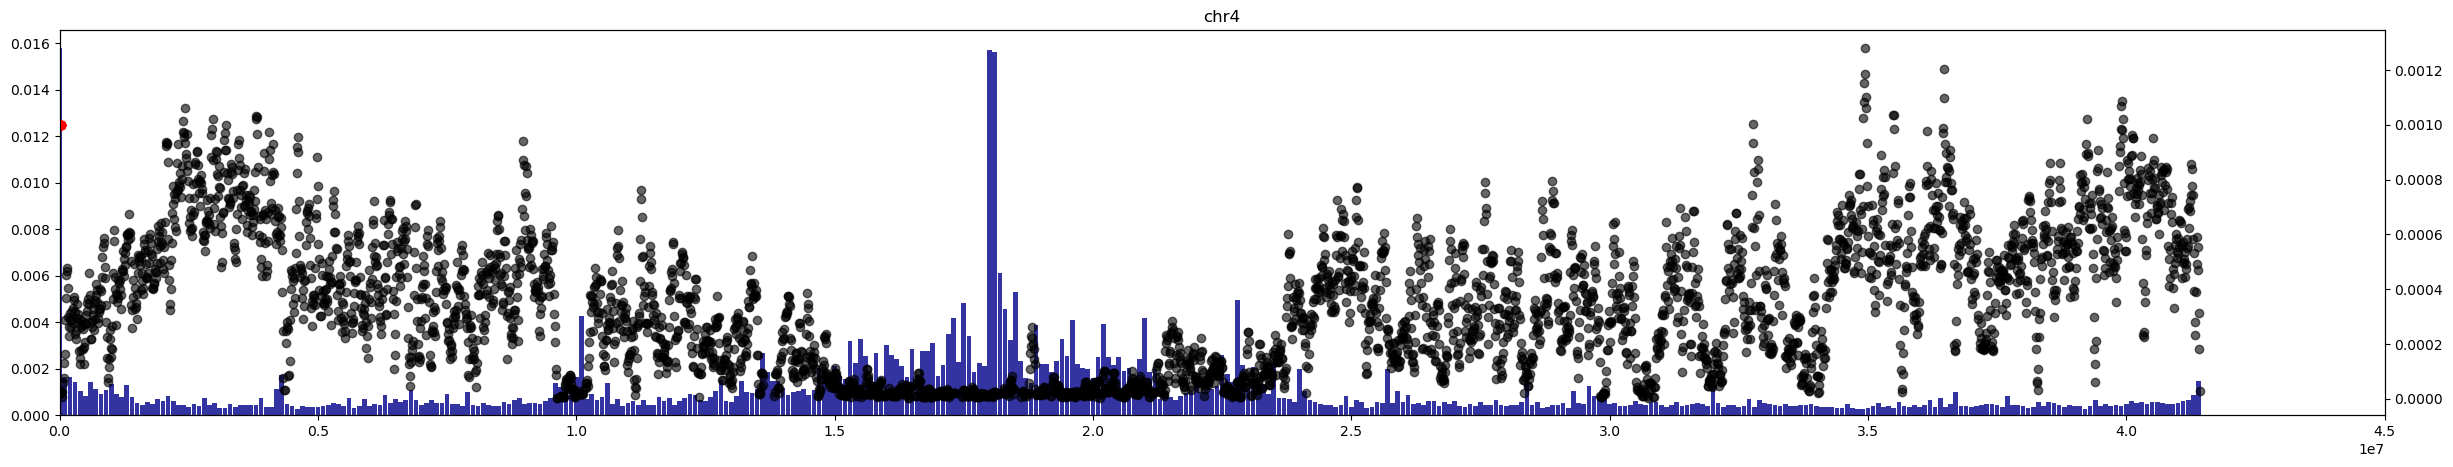

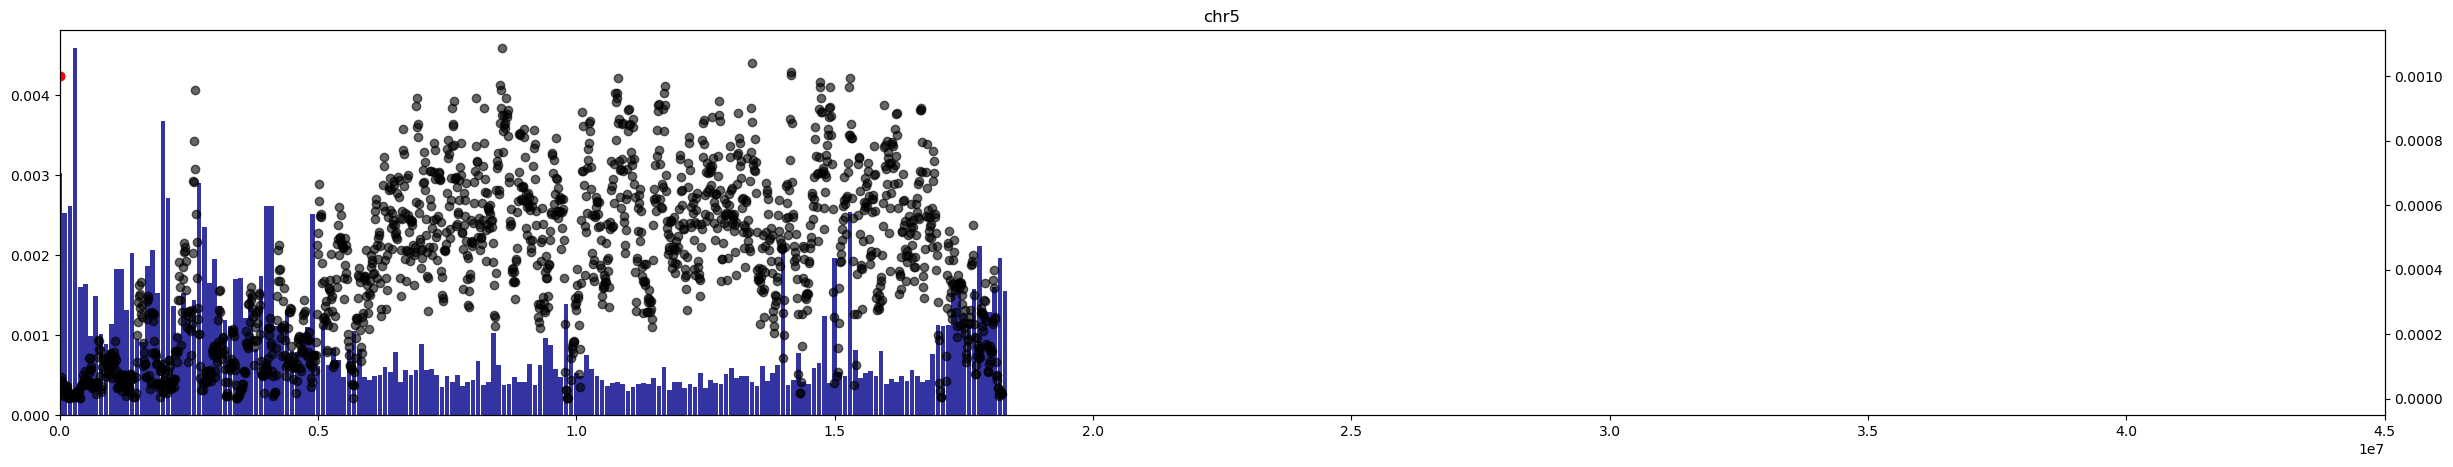

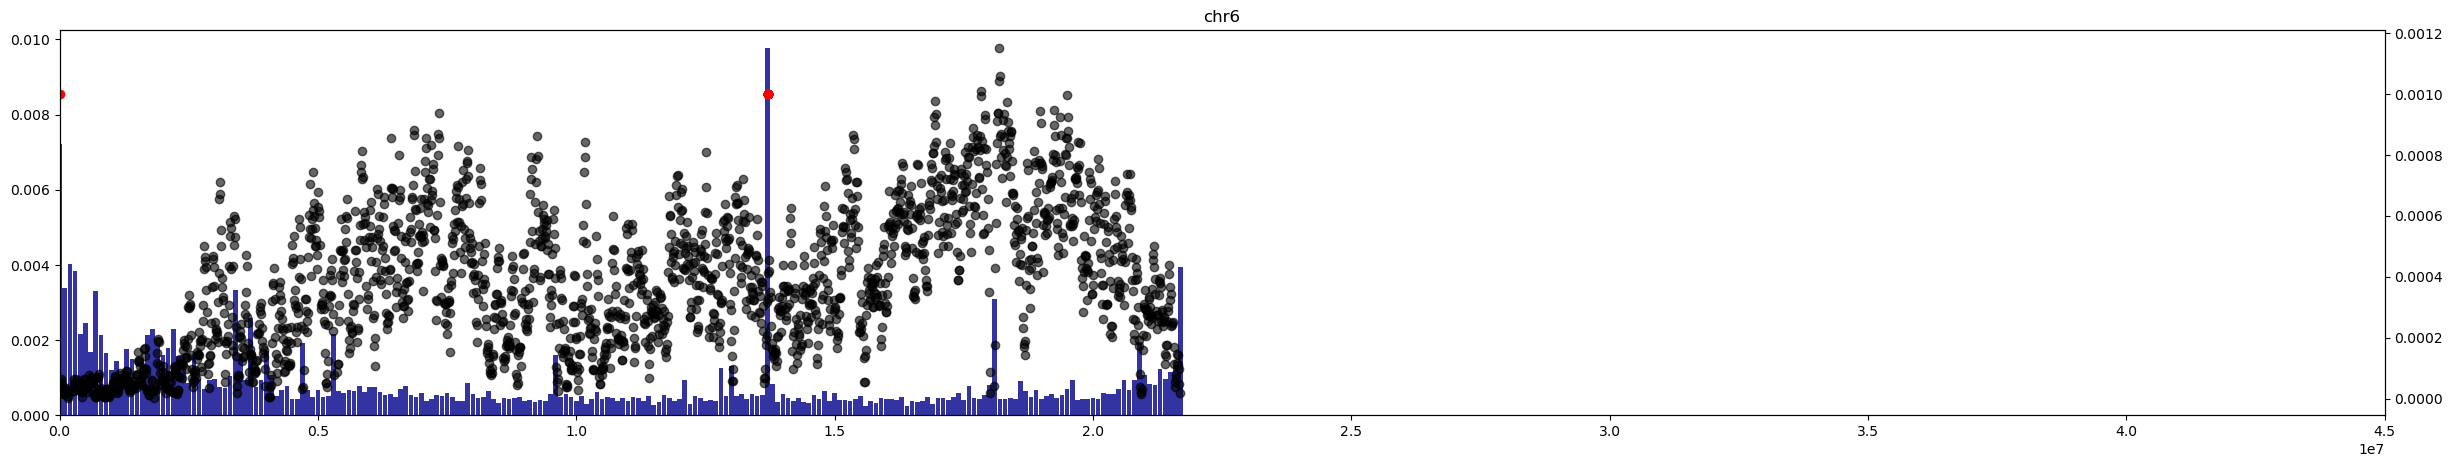

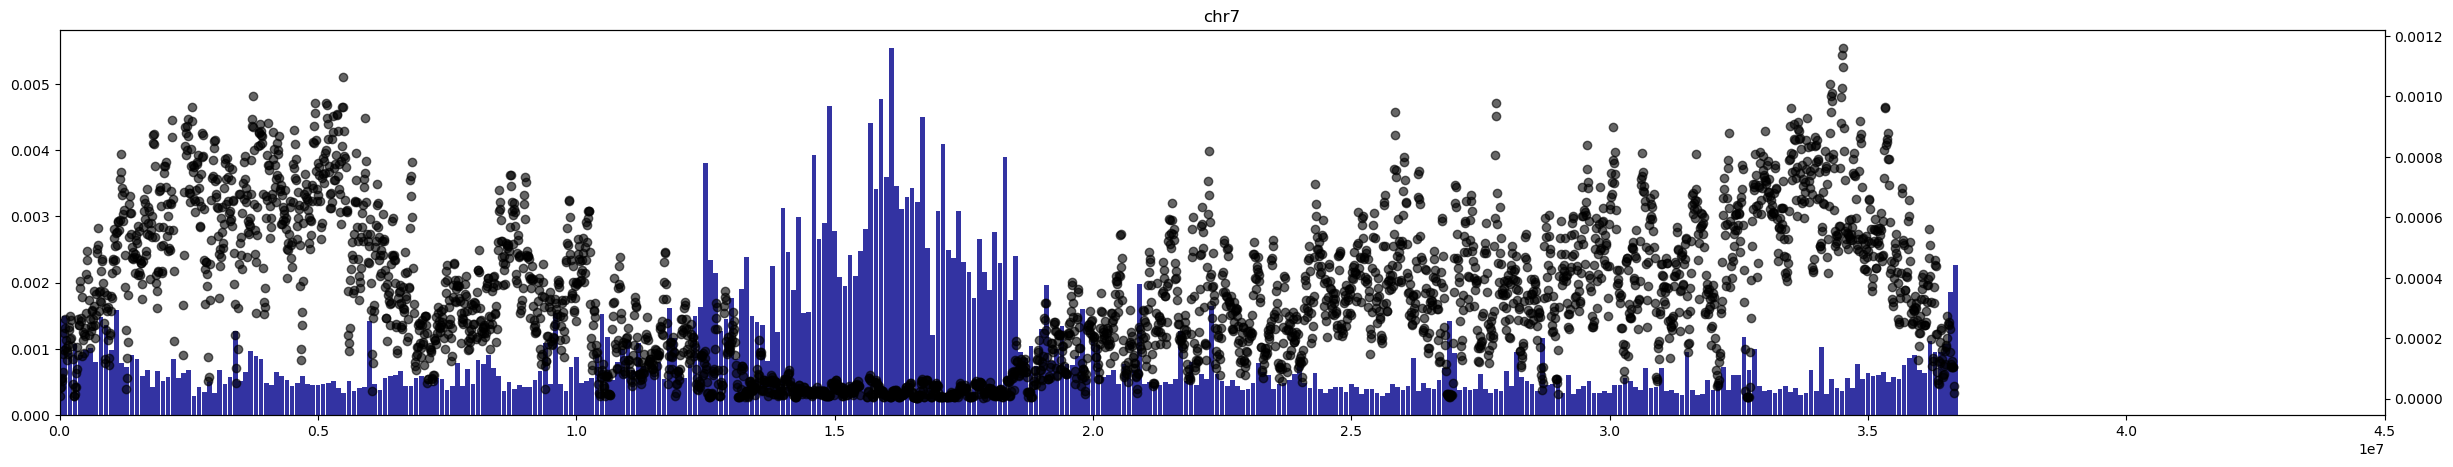

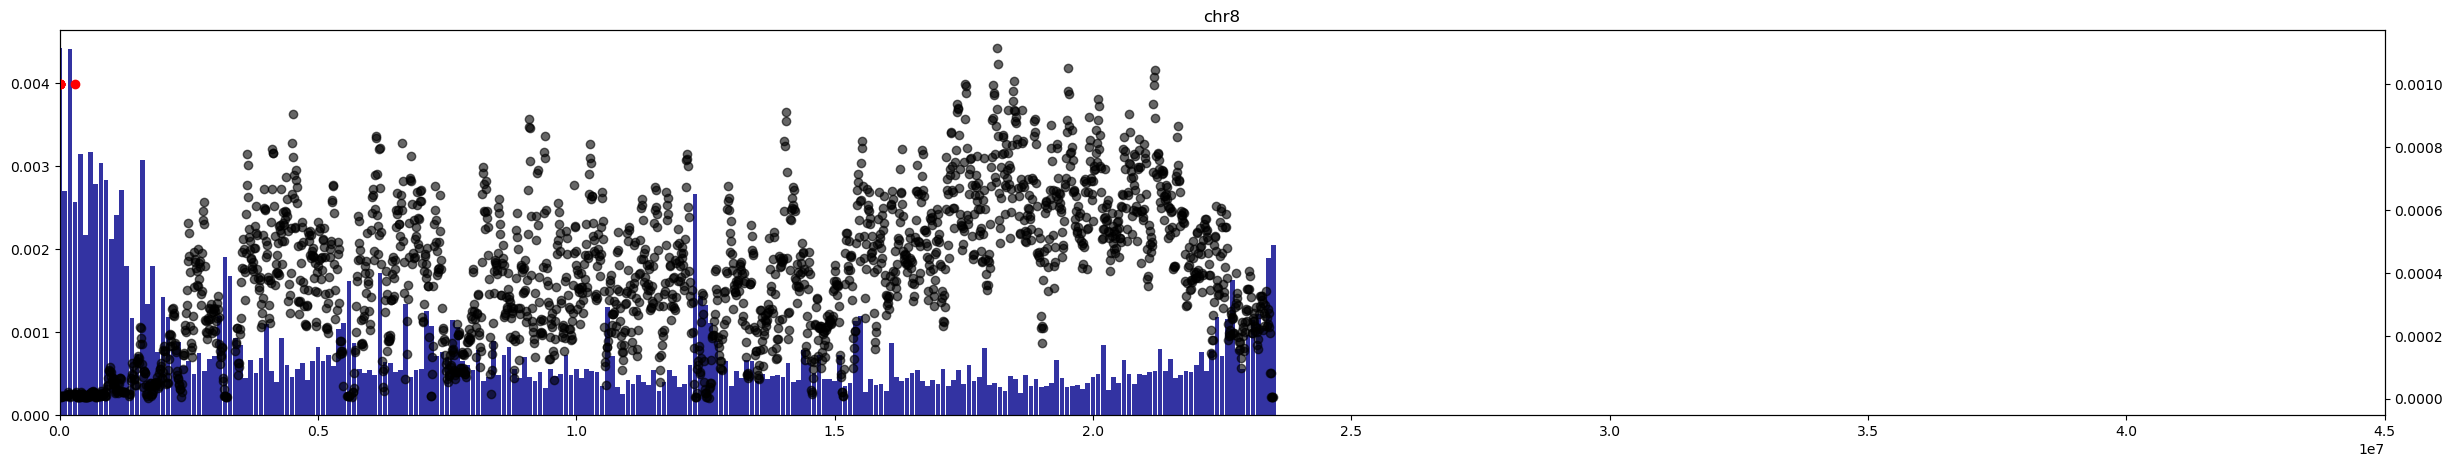

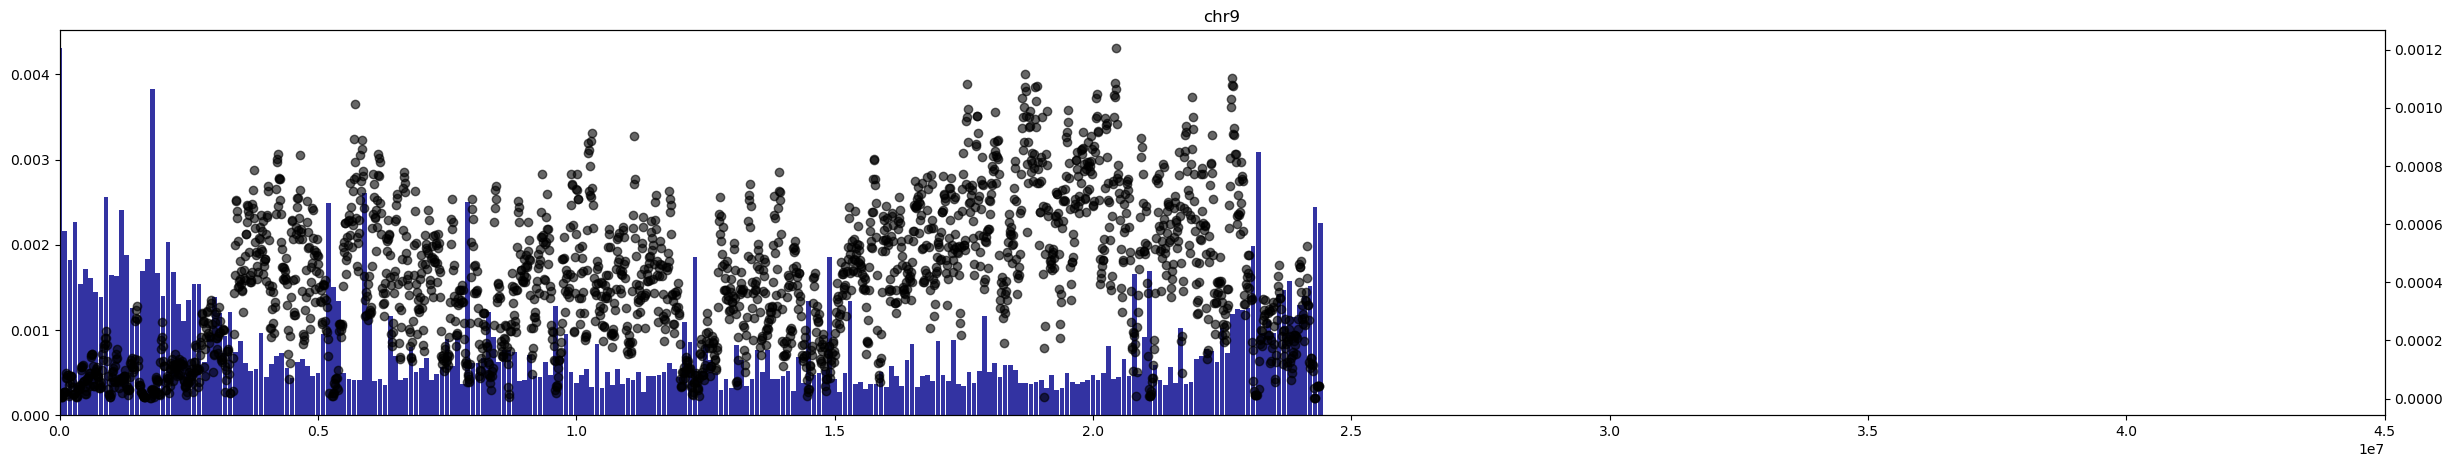

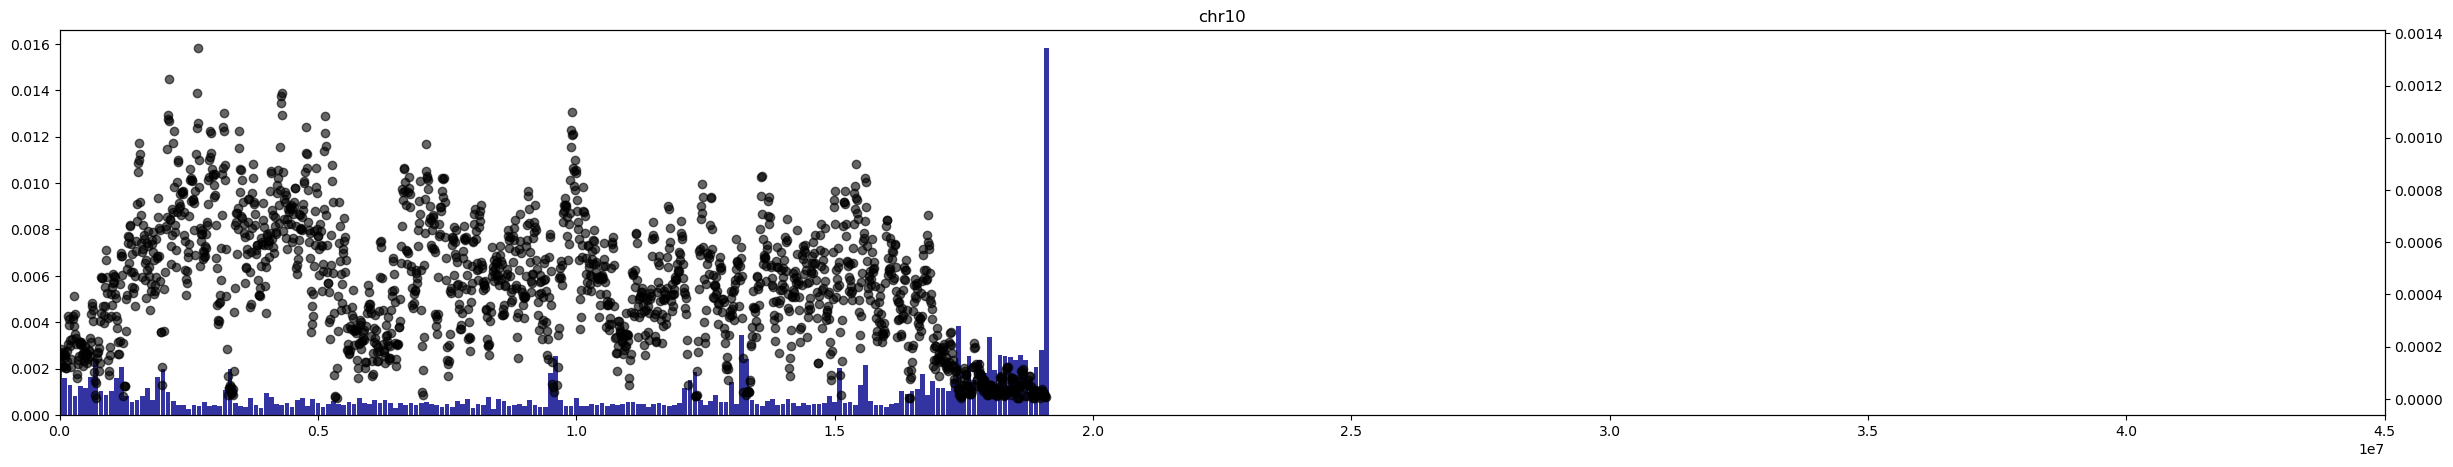

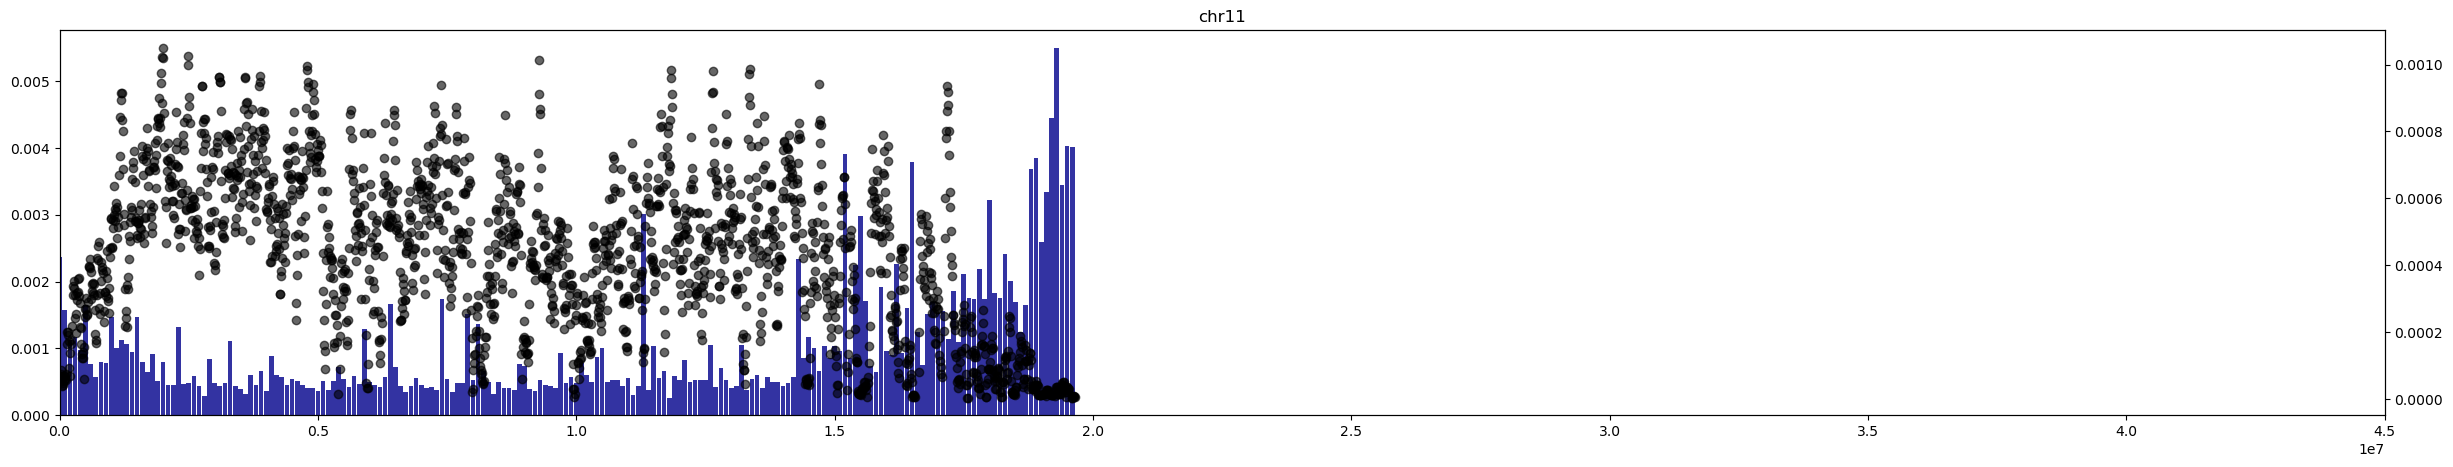

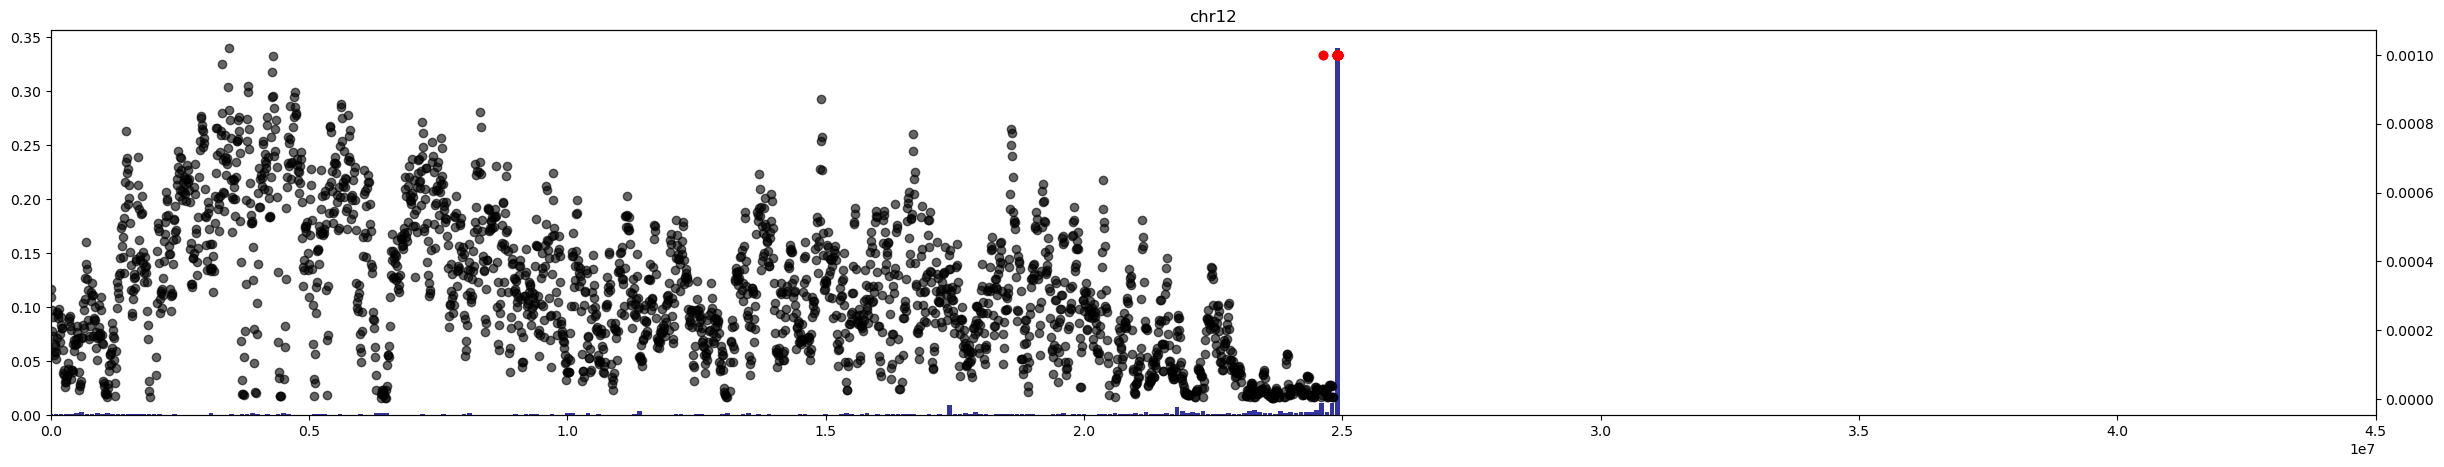

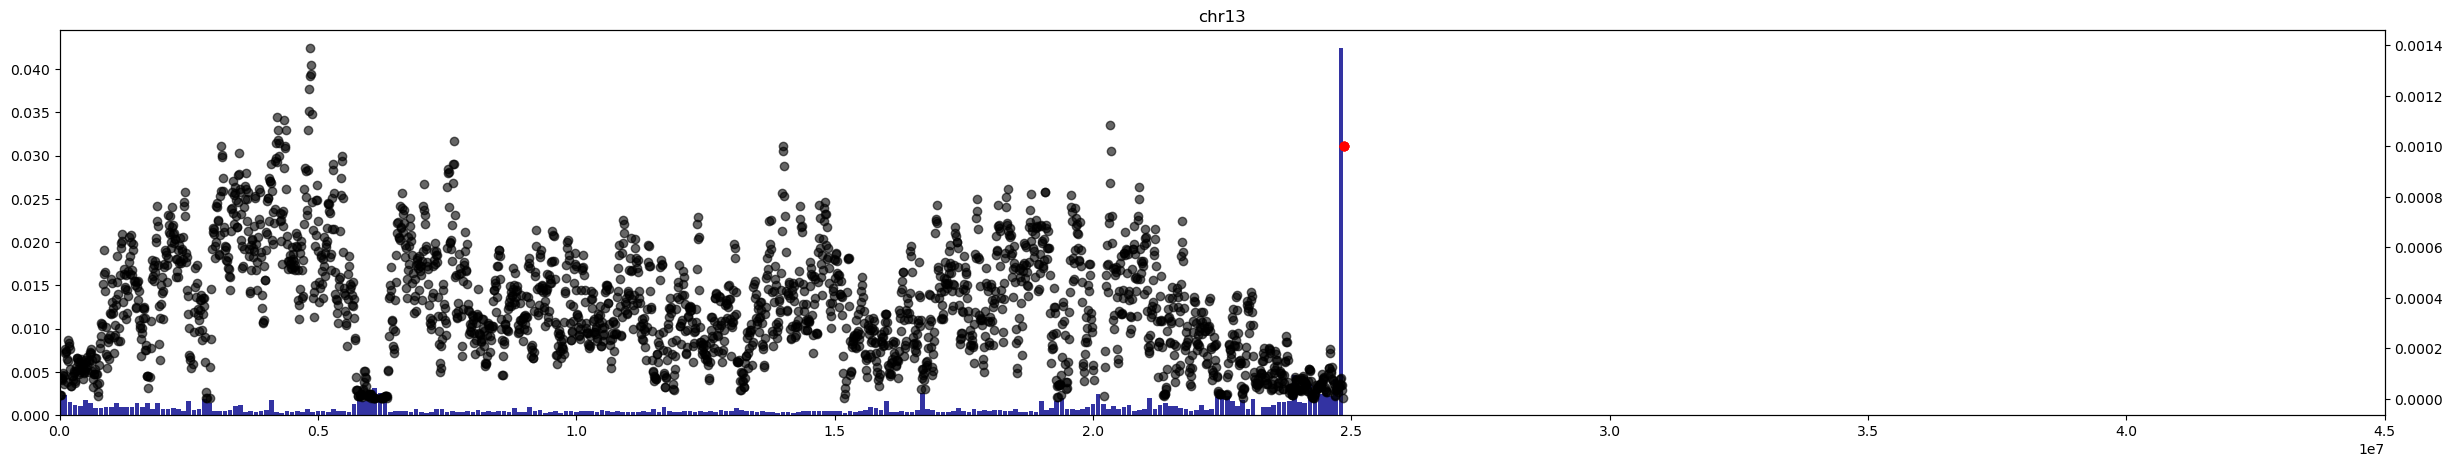

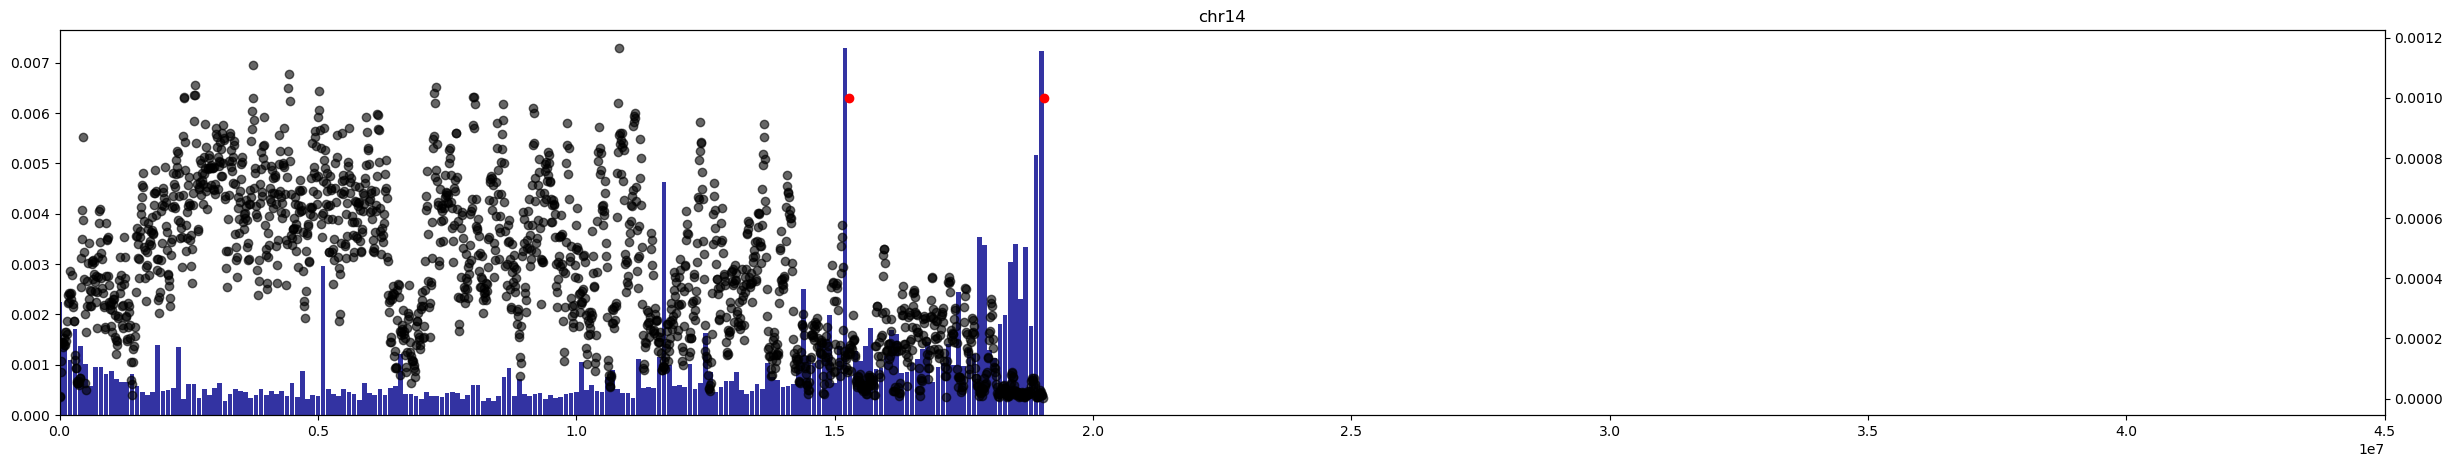

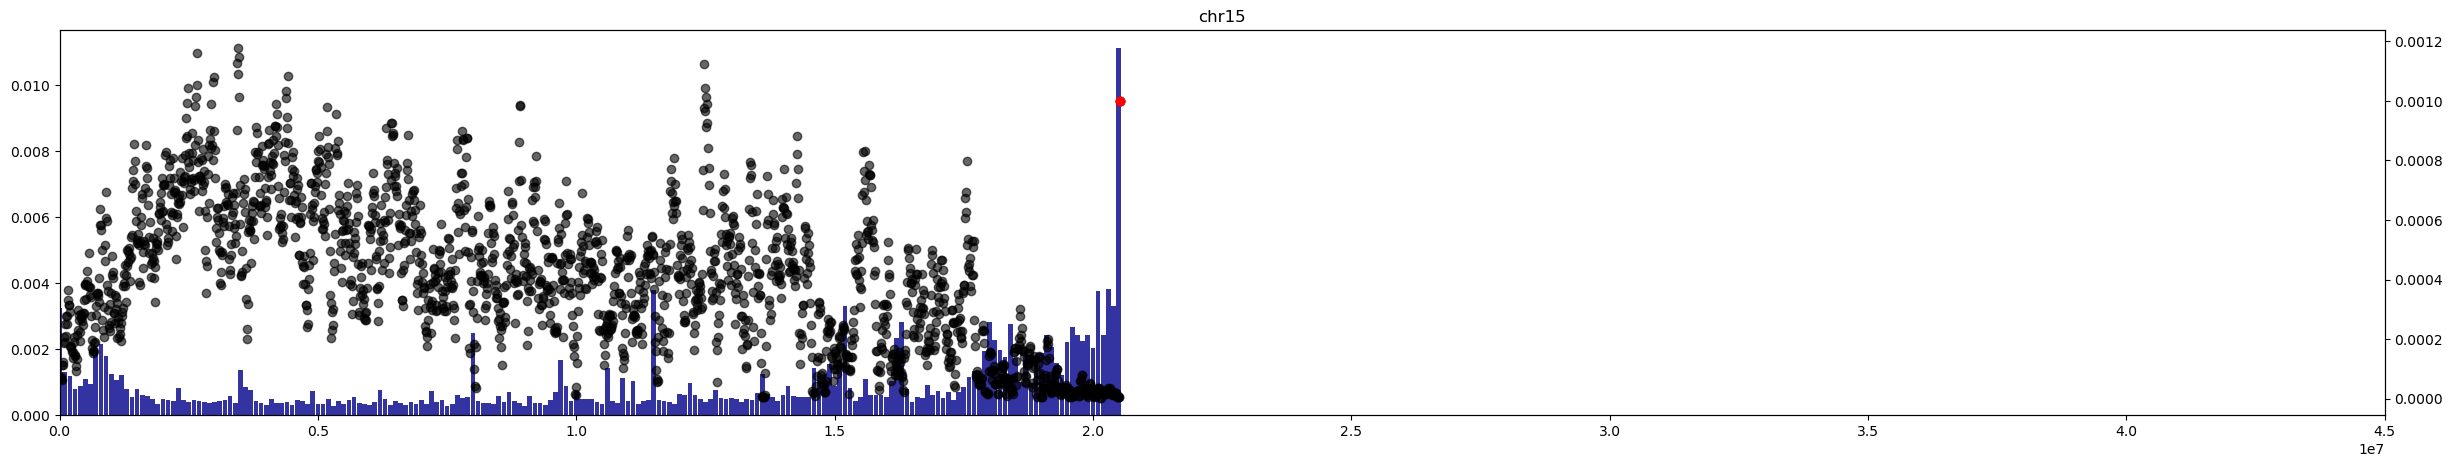

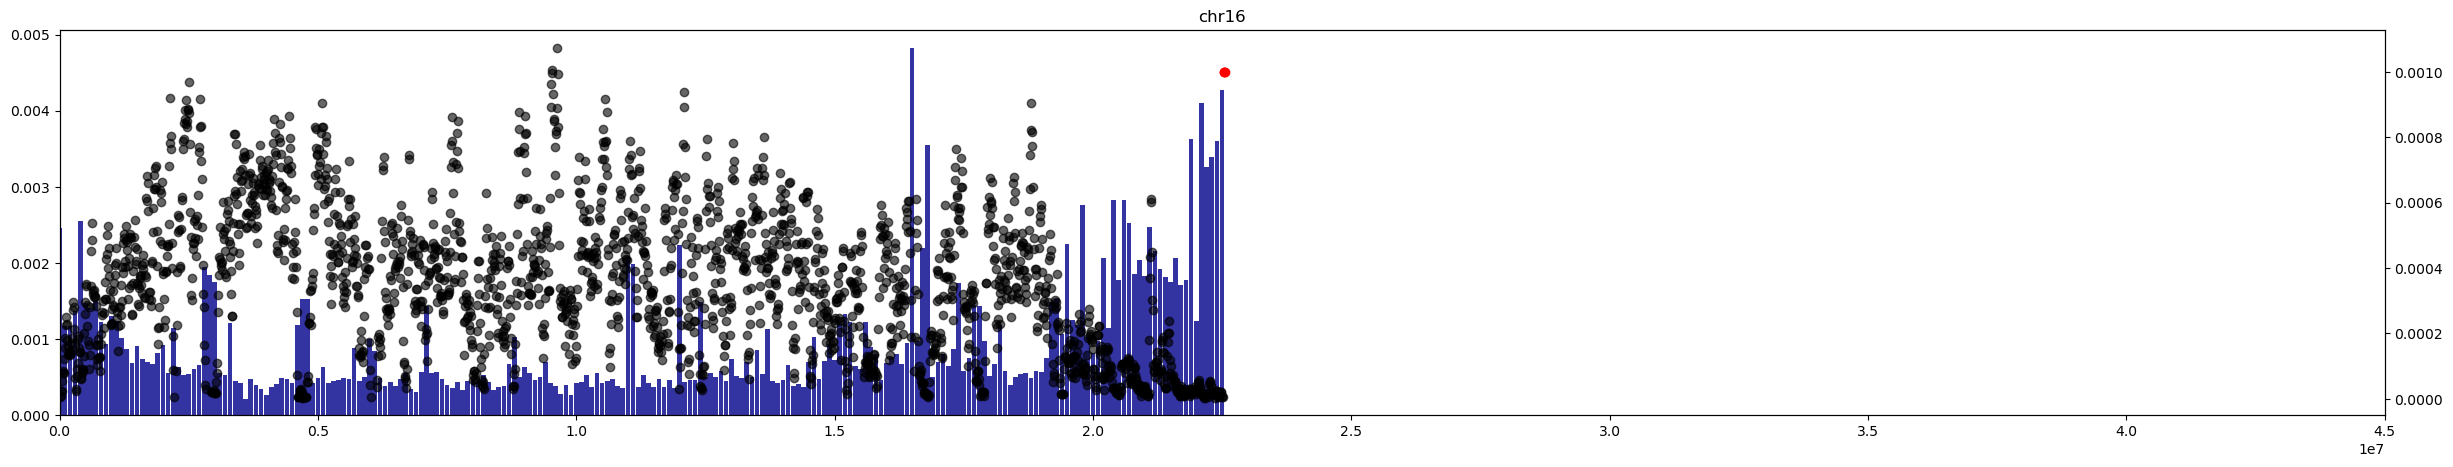

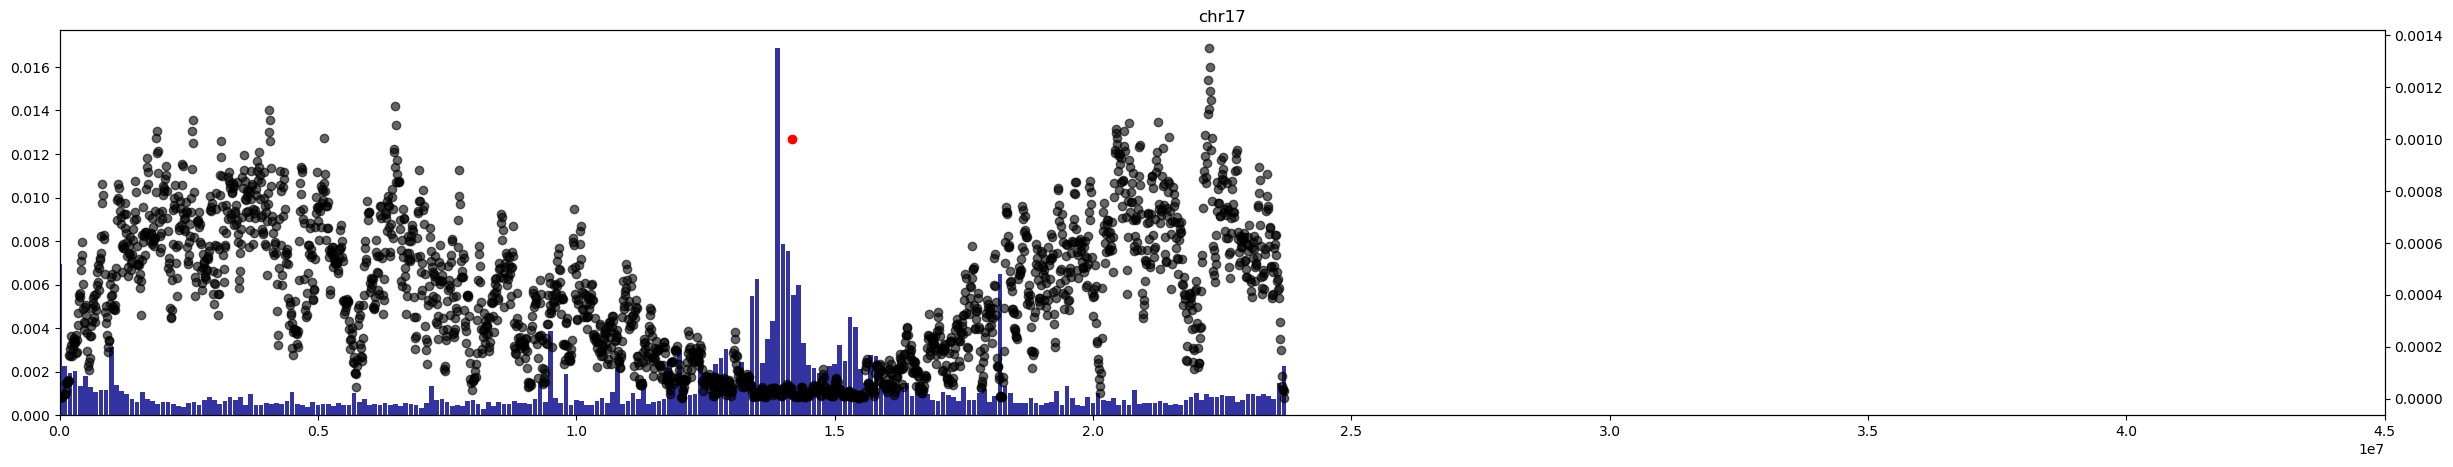

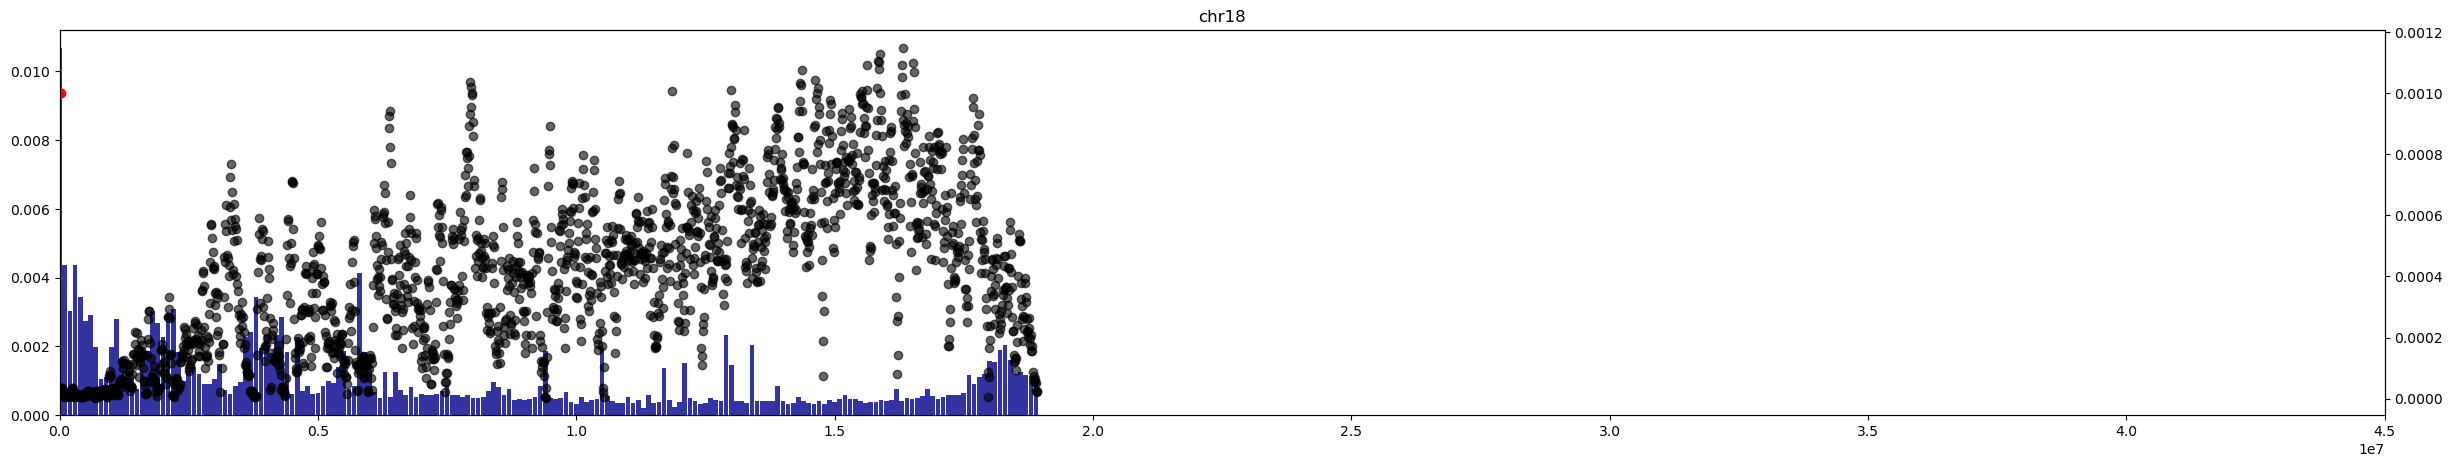

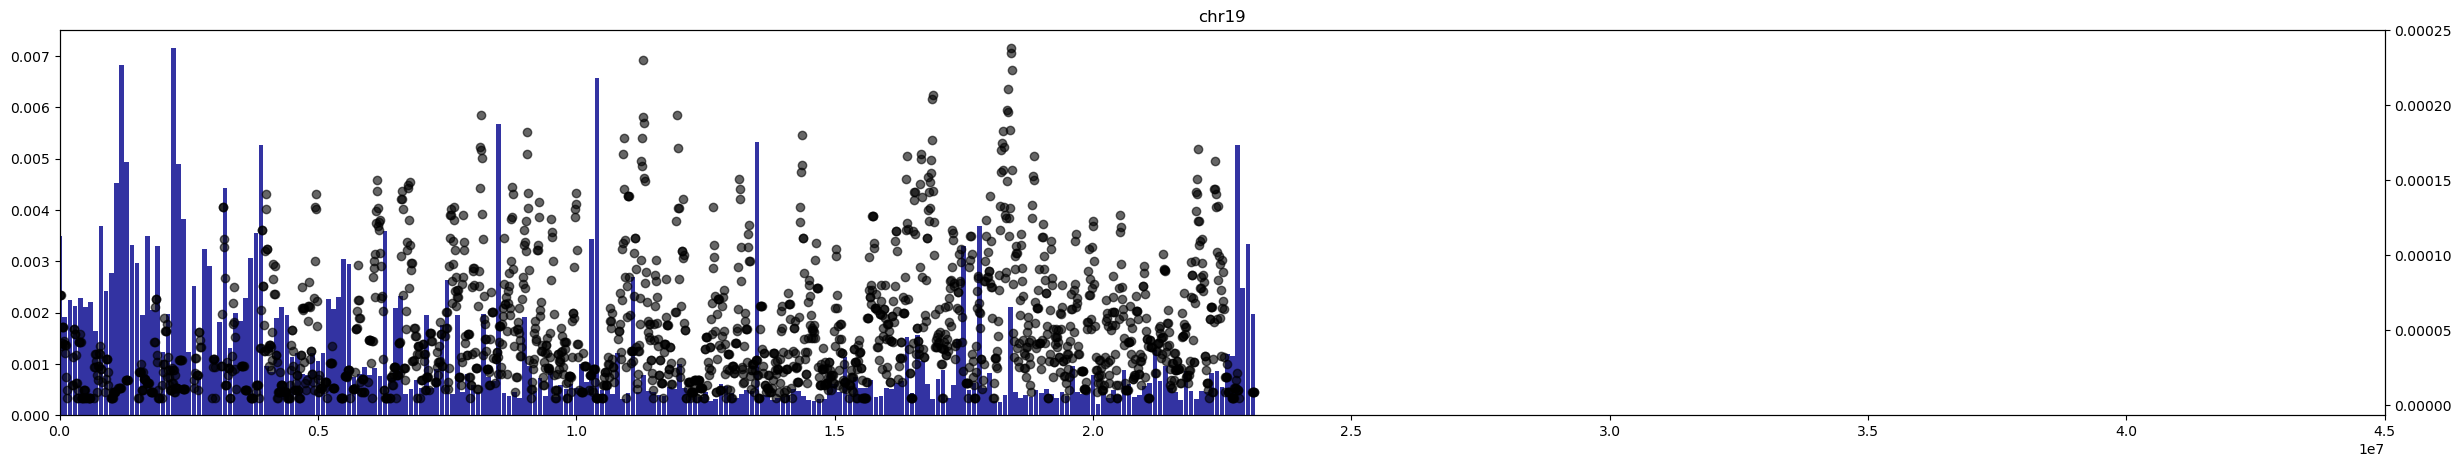

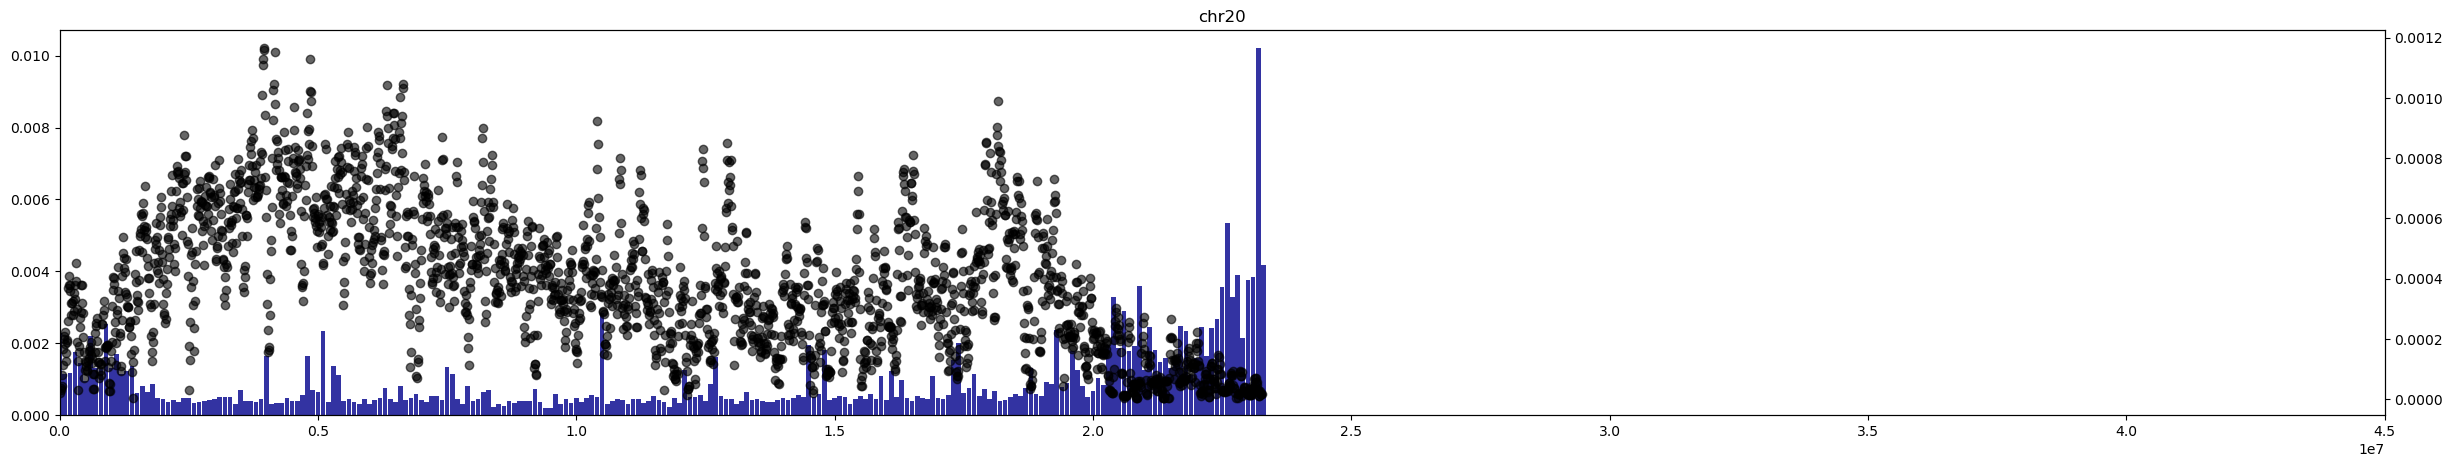

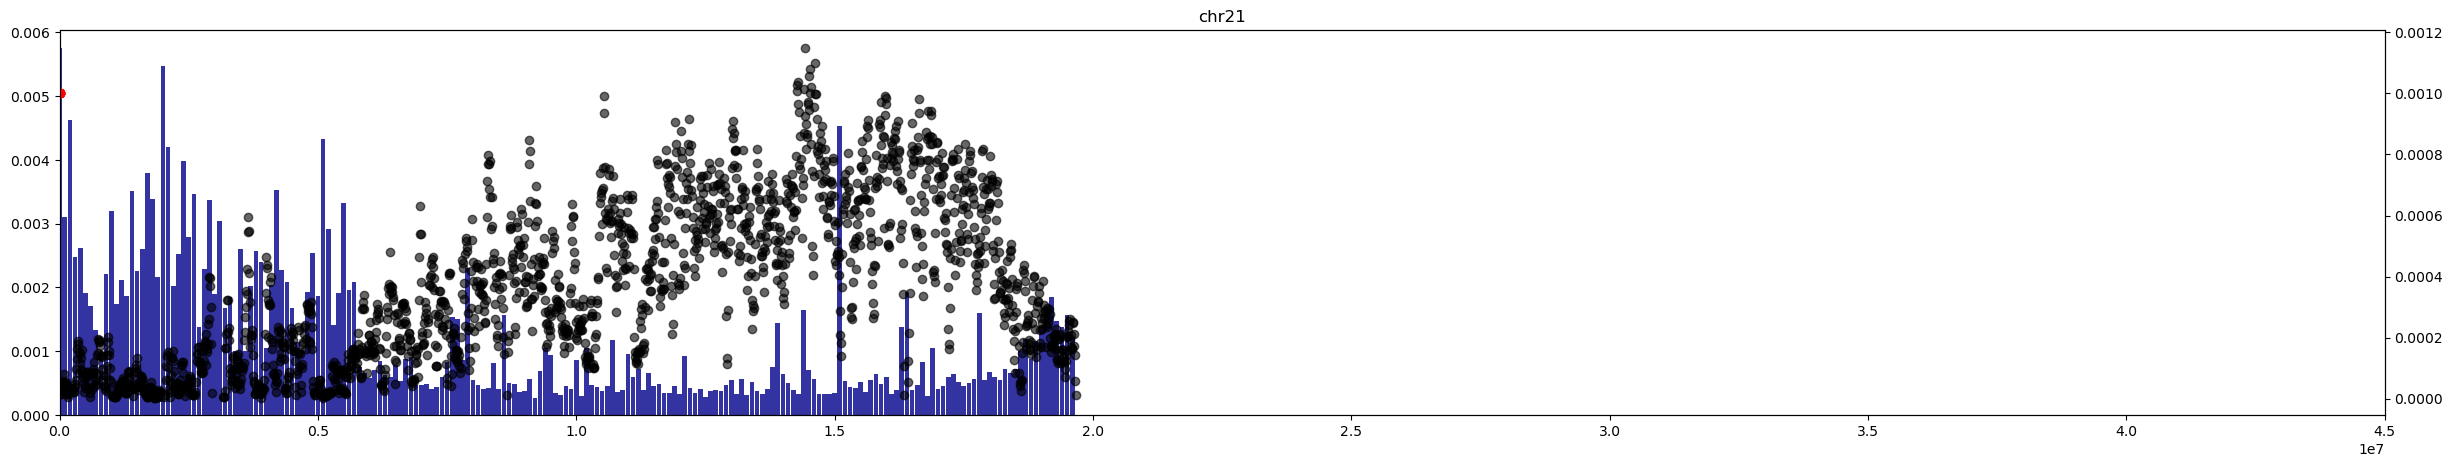

In [241]:
from matplotlib import pyplot as plt

chromosomes = ["chr1", "chr2", "chr3", "chr4", "chr5", "chr6", "chr7", "chr8", "chr9", "chr10", "chr11", "chr12", "chr13", "chr14", "chr15", "chr16", "chr17", "chr18", "chr19", "chr20", "chr21"]

for chrom in chromosomes:
    plt.figure(figsize = (30,5))
    
    plt.bar(chrom_dict[chrom]["x"], chrom_dict[chrom]["y"],  width=90000, color = "darkblue", alpha = 0.8)
    
    plt.twinx()
    
    plt.scatter(auto_pi[chrom]["POS"] , auto_pi[chrom]["PI"], color = "black", alpha = 0.6)
    
    if chrom in cent_hits:
        plt.scatter(cent_hits[chrom], [0.001]*len(cent_hits[chrom]), c = "red")
    
    plt.xlim([0,45000000])
    plt.title(chrom)
    plt.show()
    

In [245]:
bam_path = "/Users/dj20y461/Data_temp/Stickleback/Y_comp/centromeres/bam/HiC_aligned_sorted.bam"
chromosomes = ["chrY"]
binsize = 100000

chrom_dict_Y = {}

for chrom in chromosomes:

    print("Processing %s" % chrom)
    
    chrom_dict_Y[chrom] = {}

    ## get read and mate hit positions
    read_poss_Y, cent_hits_Y = get_mate_hit_counts(bam_path, cent_scaffs, chrom)

    ## calculate bin proportions
    chrom_dict_Y[chrom]["y"], chrom_dict_Y[chrom]["x"] = proportion_mate_hits(read_poss_Y, cent_hits_Y, bin_size = 100000)
    
    print("%s done!" % chrom)



Processing chrY
Chromosome: chrY, N reads: 29775191, N centromere mates: 56877 (0.002%)
chrY done!


In [247]:
chrom_dict_Y

{'chrY': {'y': [0.001183343319352906,
   0.0018777124239899524,
   0.002490263630916717,
   0.0014989806931286725,
   0.0009778782215654745,
   0.0011949914272354133,
   0.001217255006586517,
   0.003142616784474506,
   0.0017687819110138584,
   0.0011091138562741424,
   0.0009397887095728822,
   0.0012102275227742815,
   0.000890196933362401,
   0.00048781308348332184,
   0.0004565376186997809,
   0.0014796342477140481,
   0.0005802595694473995,
   0.0006399277258097909,
   0.00043546021268793544,
   0.0003912448105723042,
   0.0005050897505633693,
   0.003370082031454099,
   0.0005440084039918962,
   0.0005424637426807282,
   0.00034131281319329165,
   0.0031584279371889993,
   0.0005983212814332358,
   0.0004551809344214325,
   0.000525592987572269,
   0.003363060384950305,
   0.0003997775151220191,
   0.0051605884928163015,
   0.0020011837988669354,
   0.0014683710258931498,
   0.001845963295104029,
   0.0005108904821103183,
   0.00042894890360660237,
   0.0008175935035960257,
   0

In [248]:
with open("/Users/dj20y461/Data_temp/Stickleback/Y_comp/centromeres/cent_mate_hit_proportions_Ychrom.txt", 'w') as cent_hits_out:
    for chrom in chrom_dict_Y:
        for i in range(len(chrom_dict_Y[chrom]["x"])):
            cent_hits_out.write("%s\t%s\t%s\n" % (chrom, chrom_dict_Y[chrom]["x"][i], chrom_dict_Y[chrom]["y"][i]))
        



In [254]:
cent_hits_Y

[278,
 1292,
 1428,
 2997,
 5165,
 6048,
 6778,
 7115,
 8272,
 8272,
 11416,
 11463,
 11463,
 12848,
 13136,
 13405,
 13405,
 21035,
 23576,
 24104,
 24376,
 24376,
 27256,
 29811,
 30146,
 30496,
 31655,
 33543,
 33543,
 34955,
 35153,
 35222,
 37071,
 38171,
 38379,
 39039,
 39541,
 41202,
 41398,
 41451,
 41880,
 41882,
 42065,
 43880,
 44296,
 45315,
 47044,
 49518,
 50057,
 50661,
 50676,
 51587,
 56625,
 58511,
 59098,
 63356,
 67179,
 67305,
 68138,
 70349,
 70349,
 76395,
 76395,
 77404,
 78105,
 79590,
 80351,
 86163,
 87966,
 88308,
 88310,
 88310,
 88773,
 88896,
 90752,
 96455,
 98078,
 98596,
 98602,
 100227,
 102887,
 104505,
 107497,
 108275,
 108275,
 108275,
 108923,
 112802,
 117353,
 117407,
 117564,
 117591,
 117617,
 117627,
 119764,
 125626,
 128861,
 130181,
 132801,
 135197,
 135414,
 136493,
 136725,
 136725,
 137318,
 138556,
 138637,
 139508,
 142779,
 143107,
 145378,
 149325,
 150074,
 150126,
 151198,
 153002,
 156336,
 158339,
 161869,
 161869,
 166663,
 

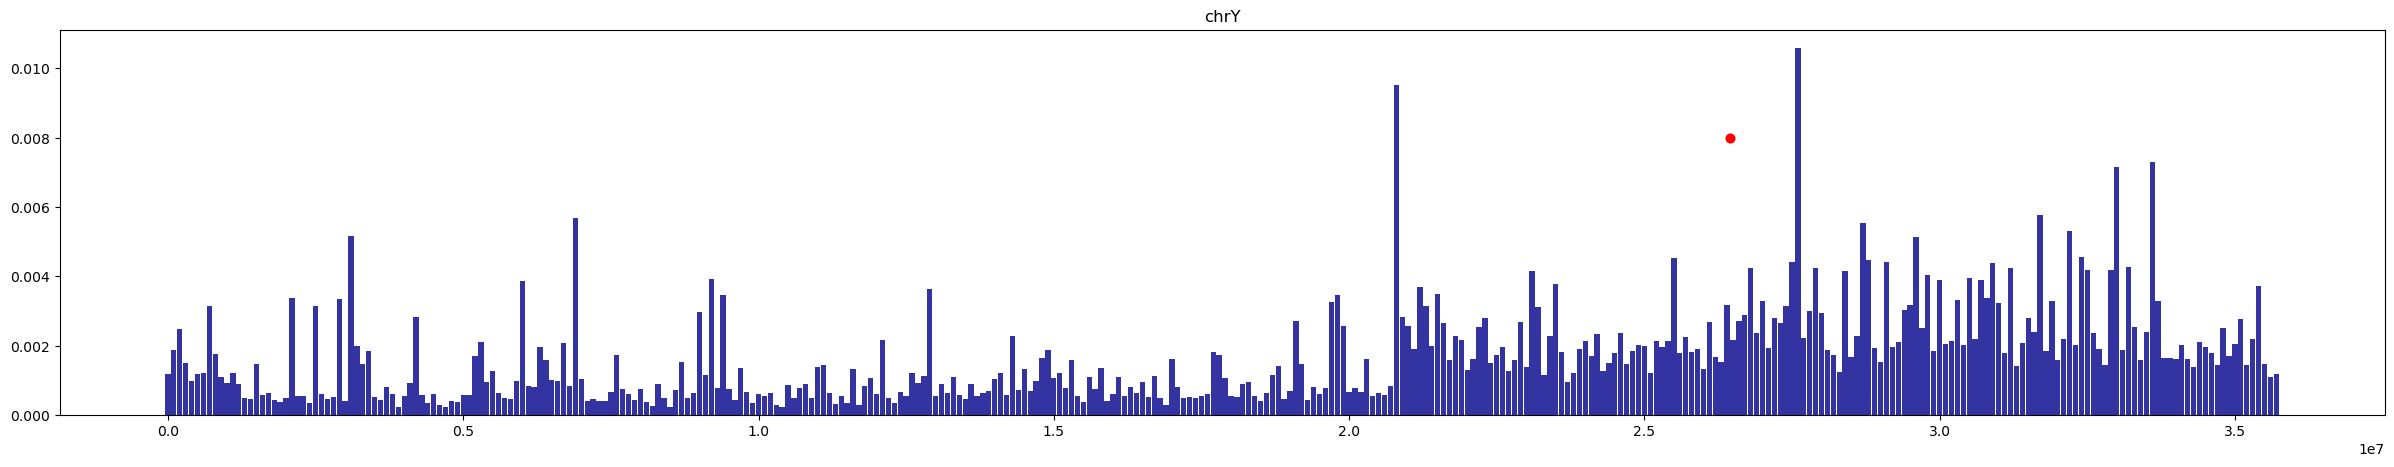

In [259]:
from matplotlib import pyplot as plt

chromosomes = ["chrY"]

for chrom in chromosomes:
    plt.figure(figsize = (30,5))
    
    plt.bar(chrom_dict_Y[chrom]["x"], chrom_dict_Y[chrom]["y"],  width=90000, color = "darkblue", alpha = 0.8)
    
    #plt.twinx()
    
    #plt.scatter(auto_pi[chrom]["POS"] , auto_pi[chrom]["PI"], color = "black", alpha = 0.6)
    
    if chrom in cent_hits:
        plt.scatter(cent_hits[chrom], [0.008]*len(cent_hits[chrom]), c = "red")
    
    #plt.xlim([0,45000000])
    plt.title(chrom)
    plt.show()
    

### All samples

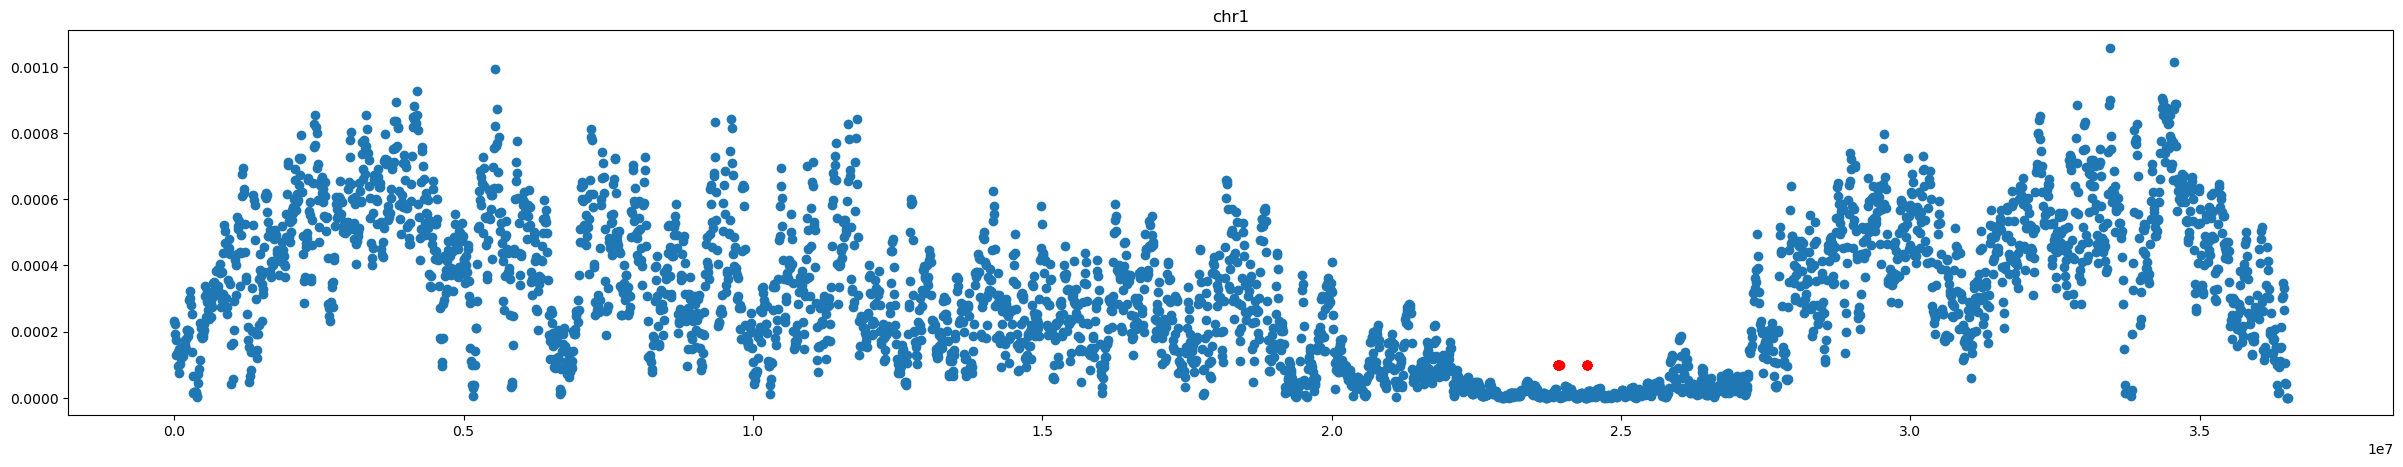

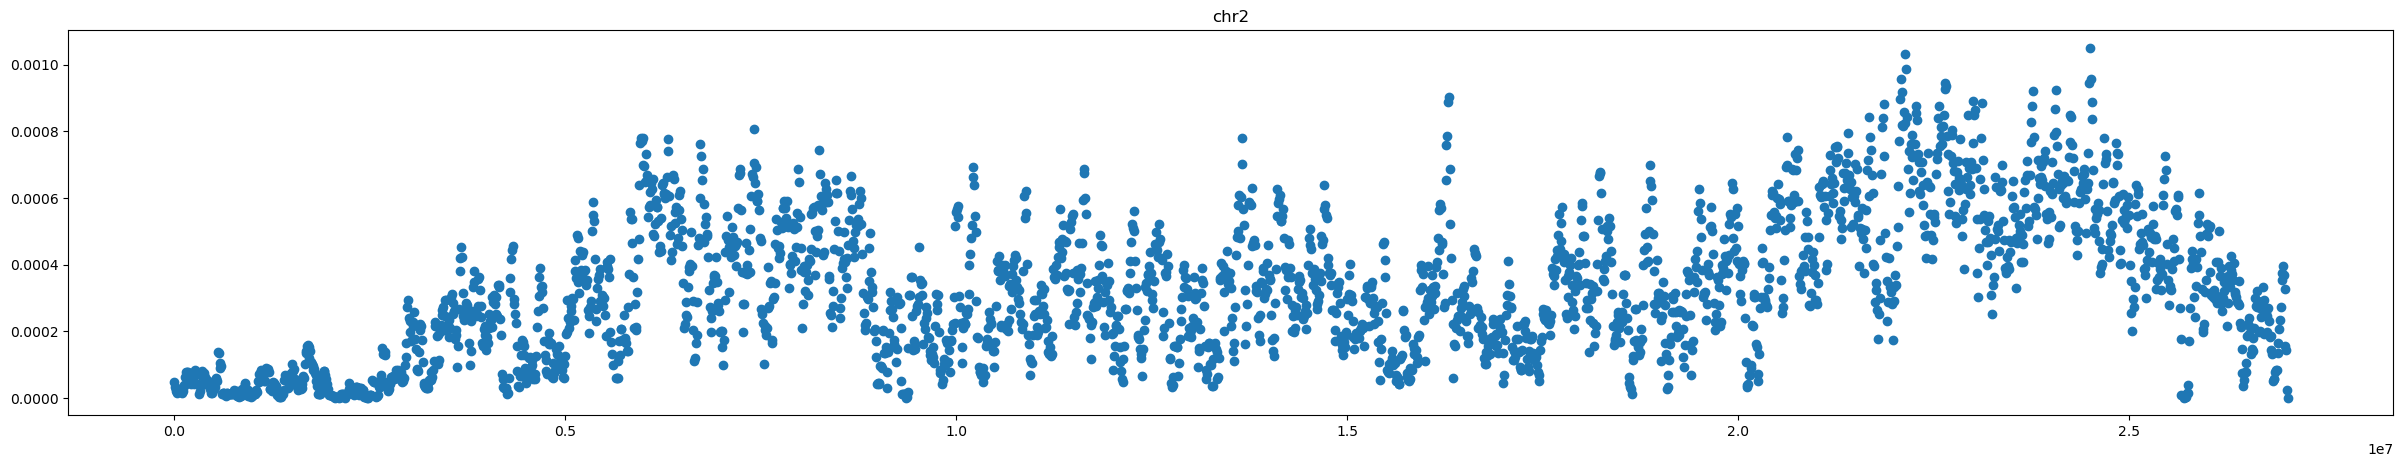

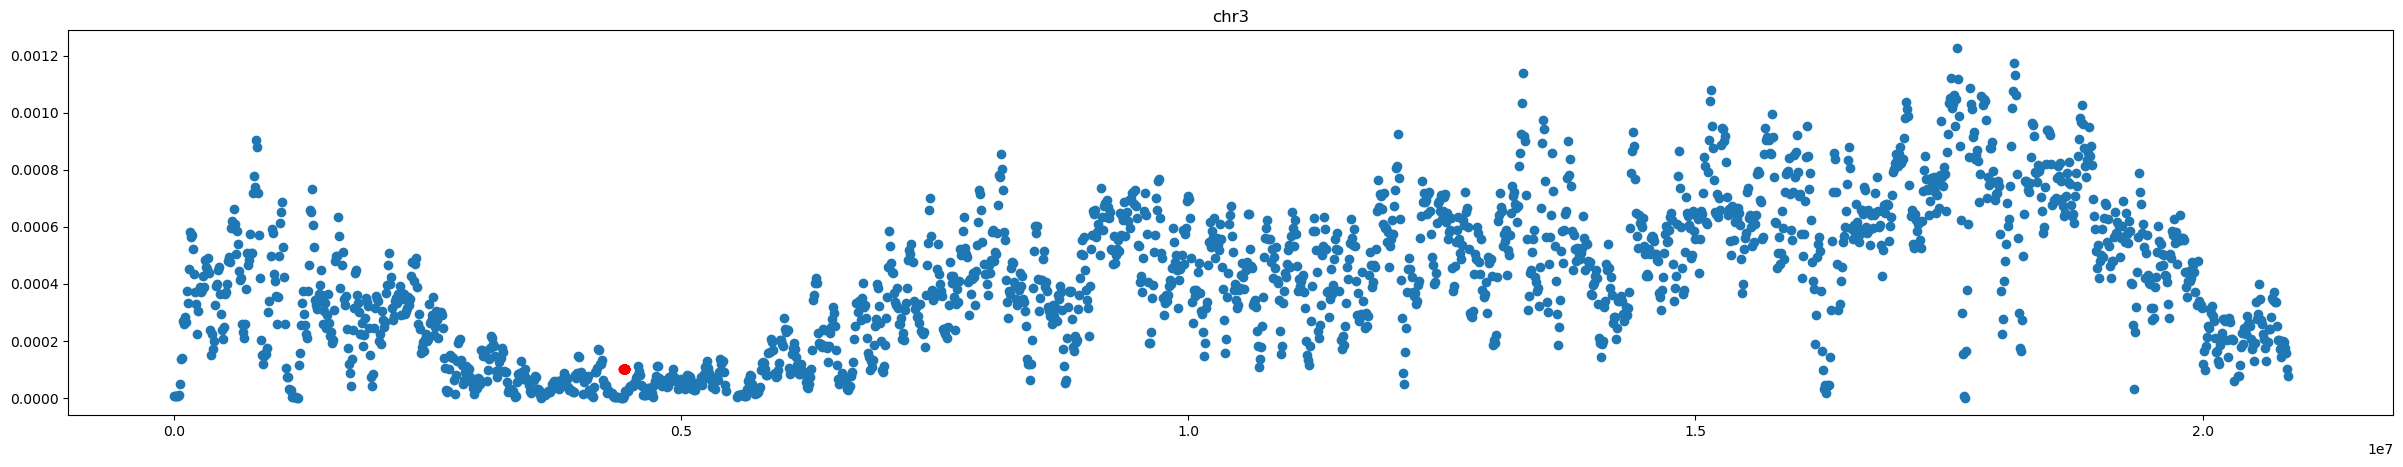

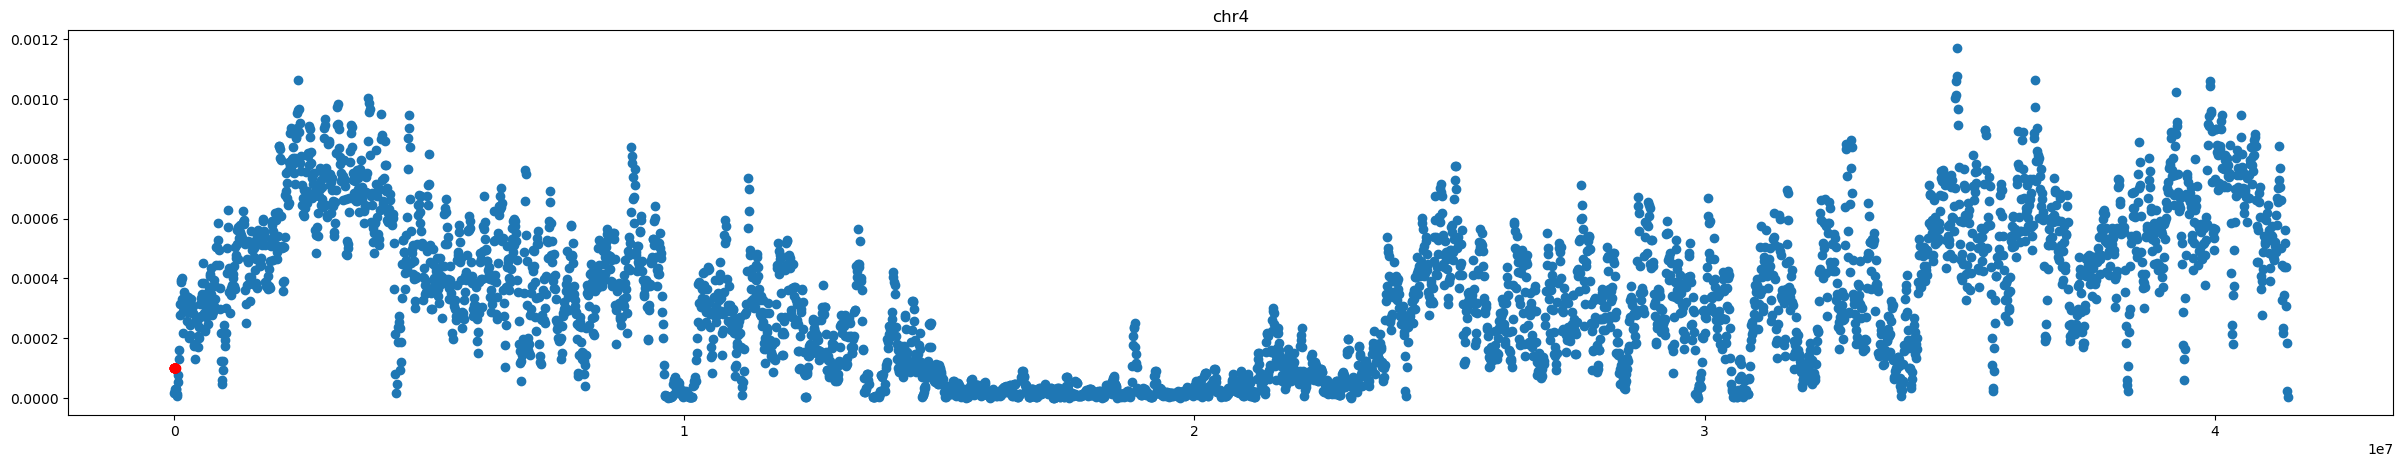

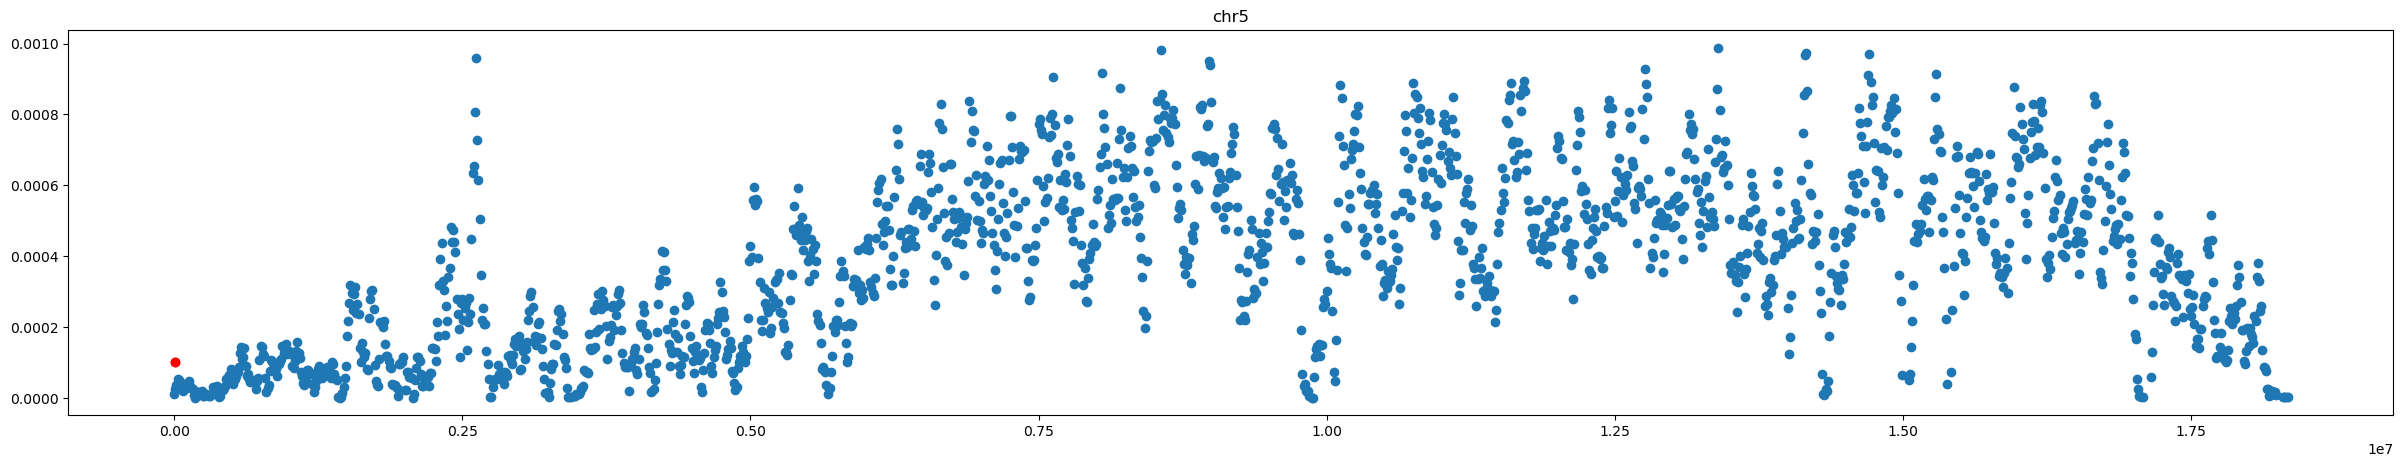

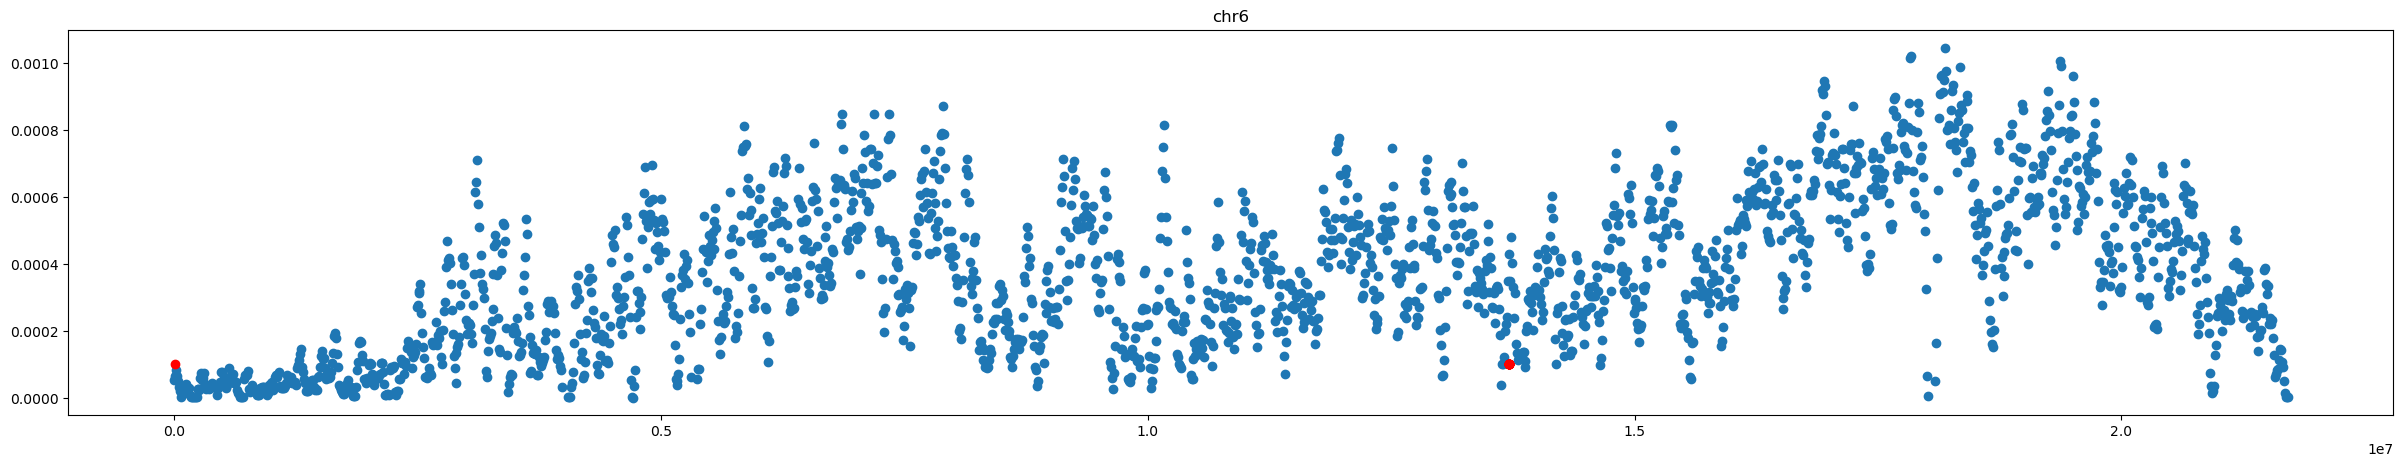

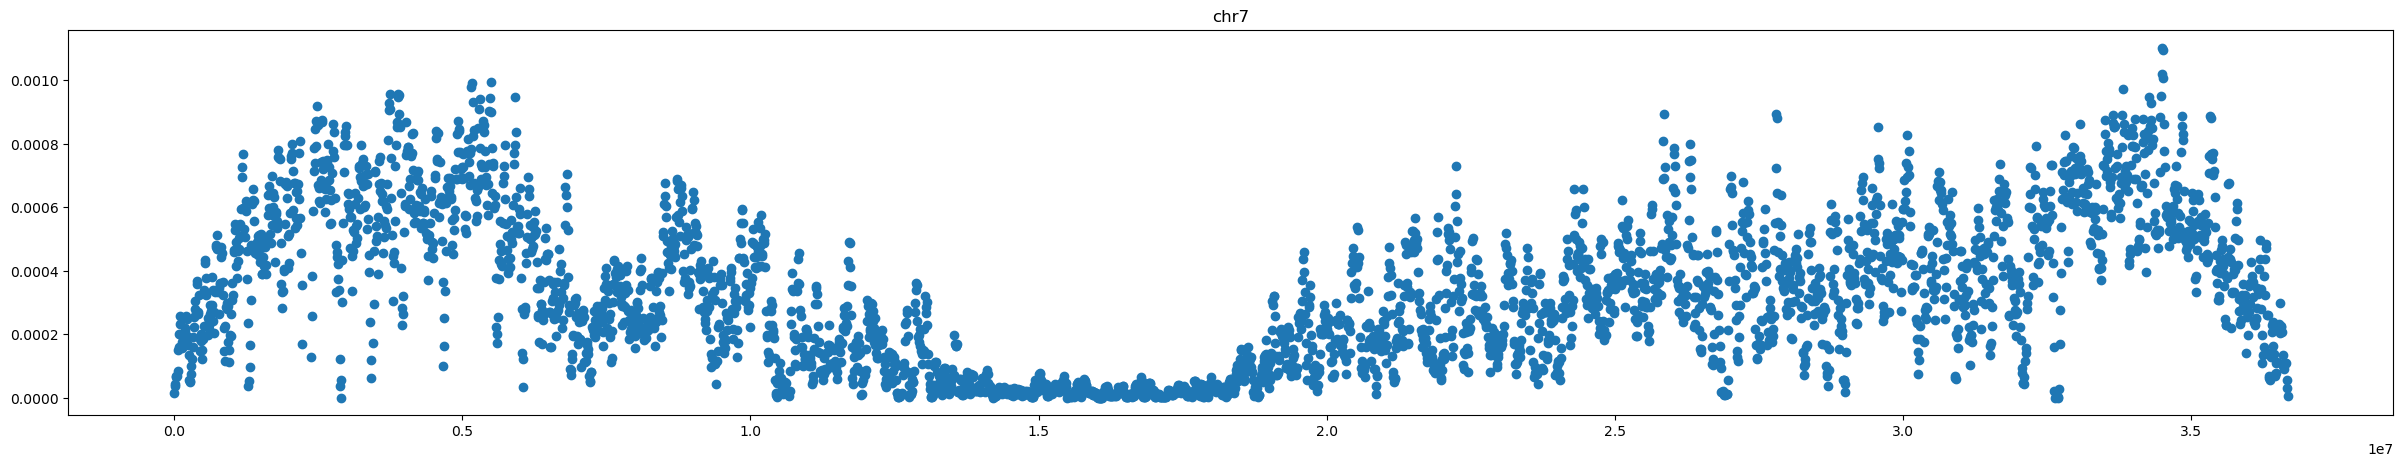

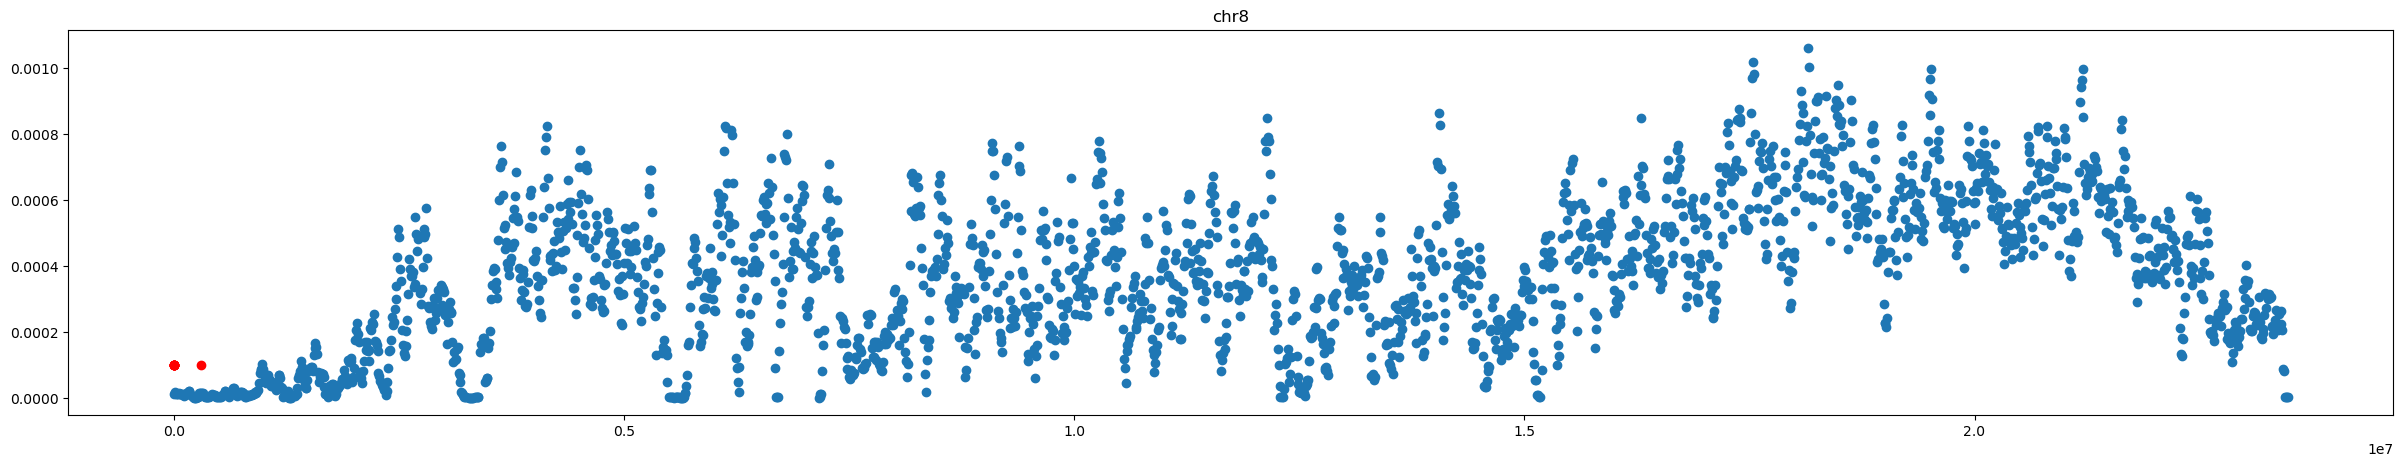

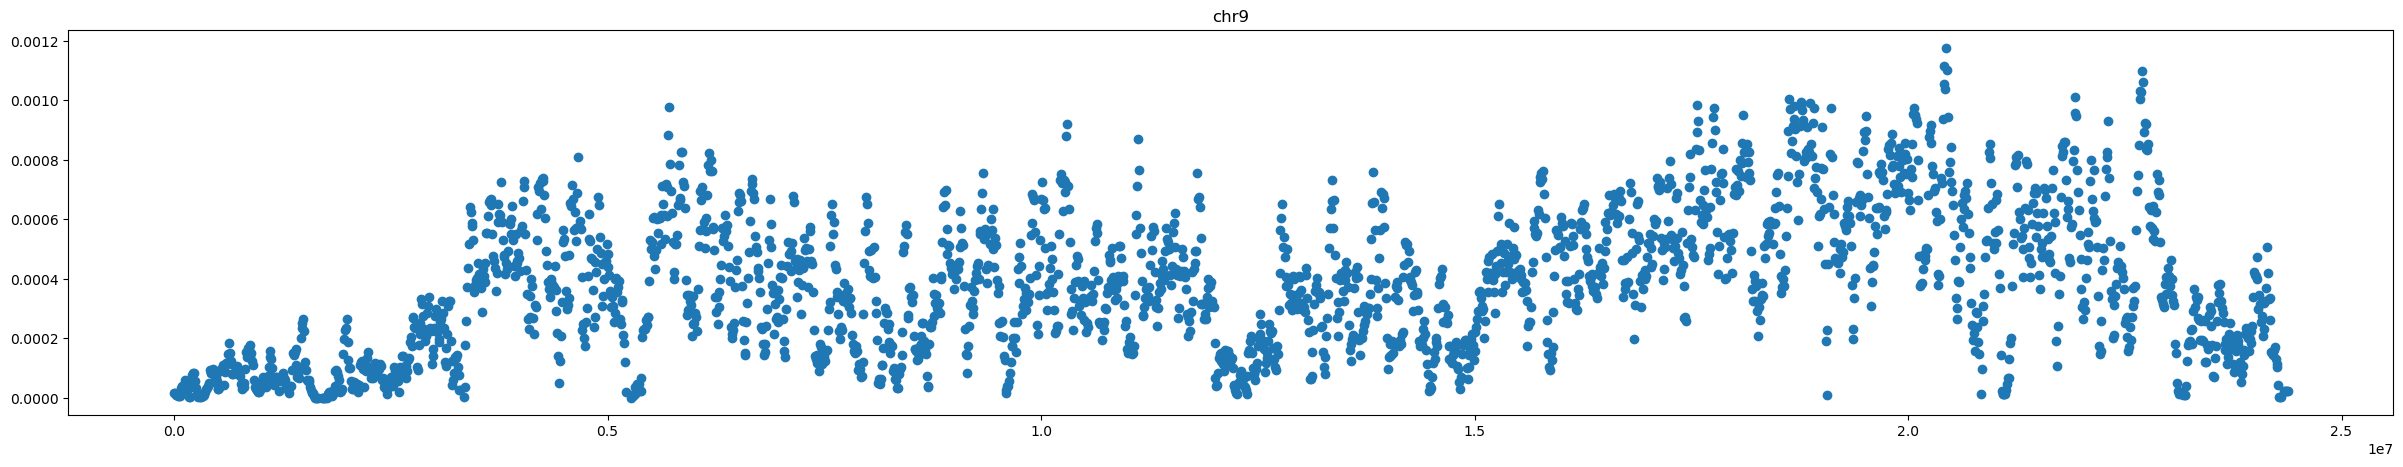

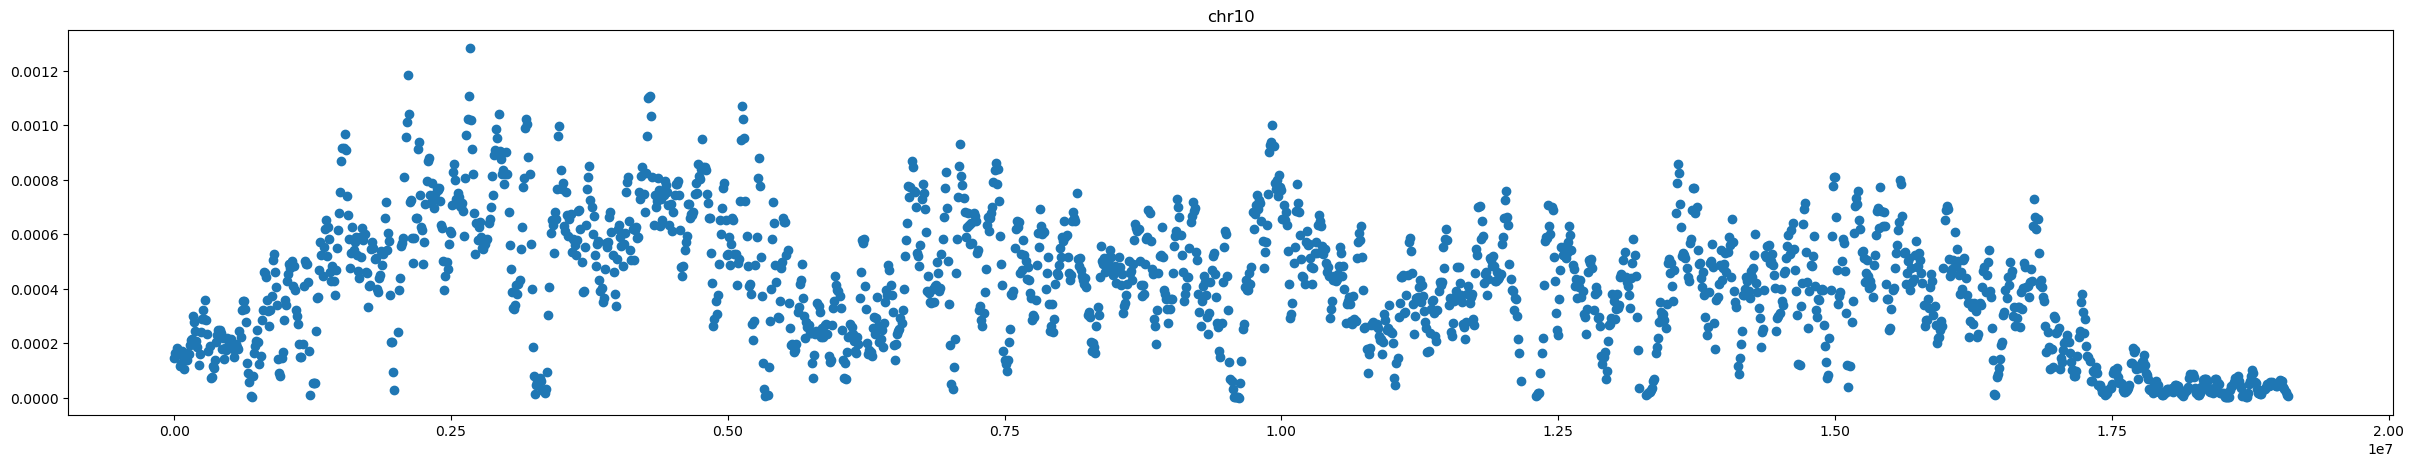

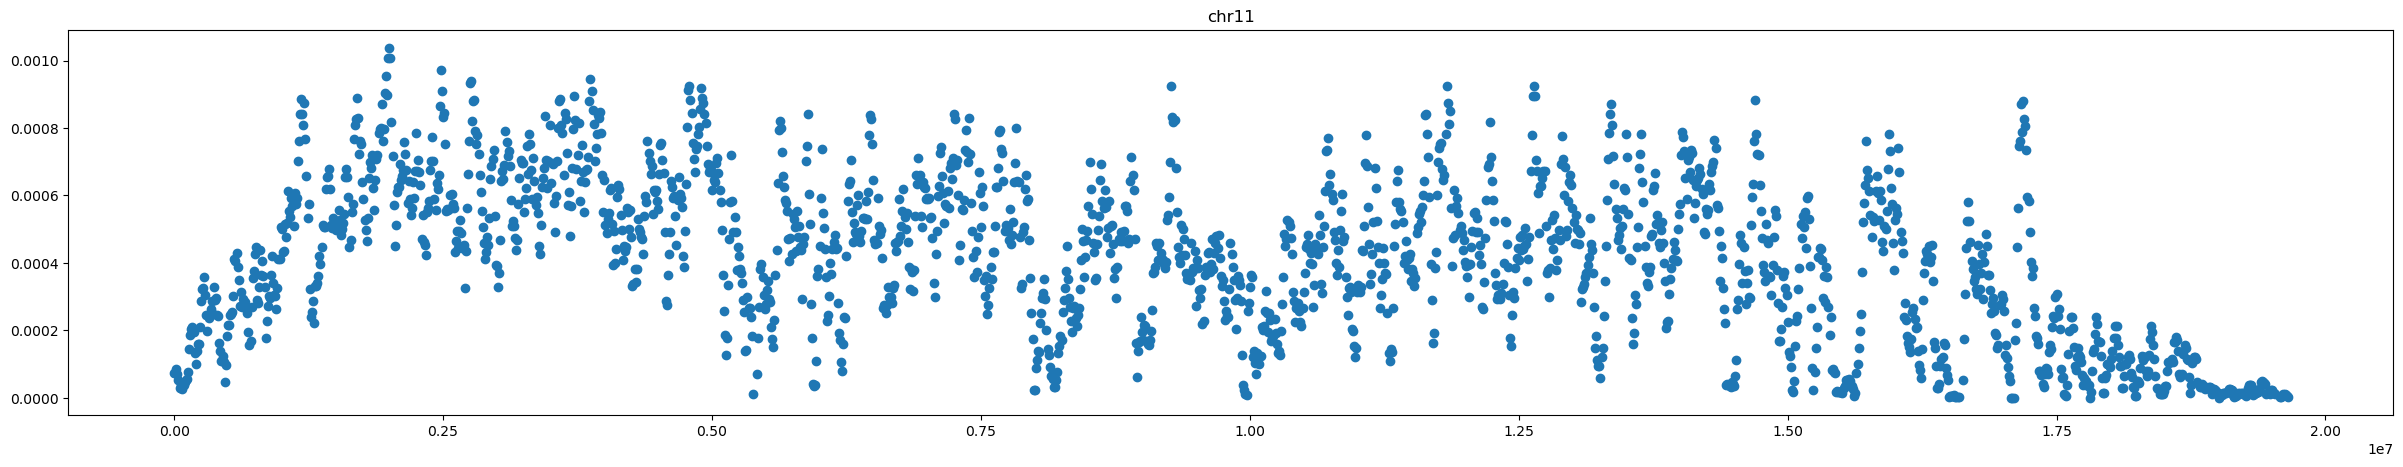

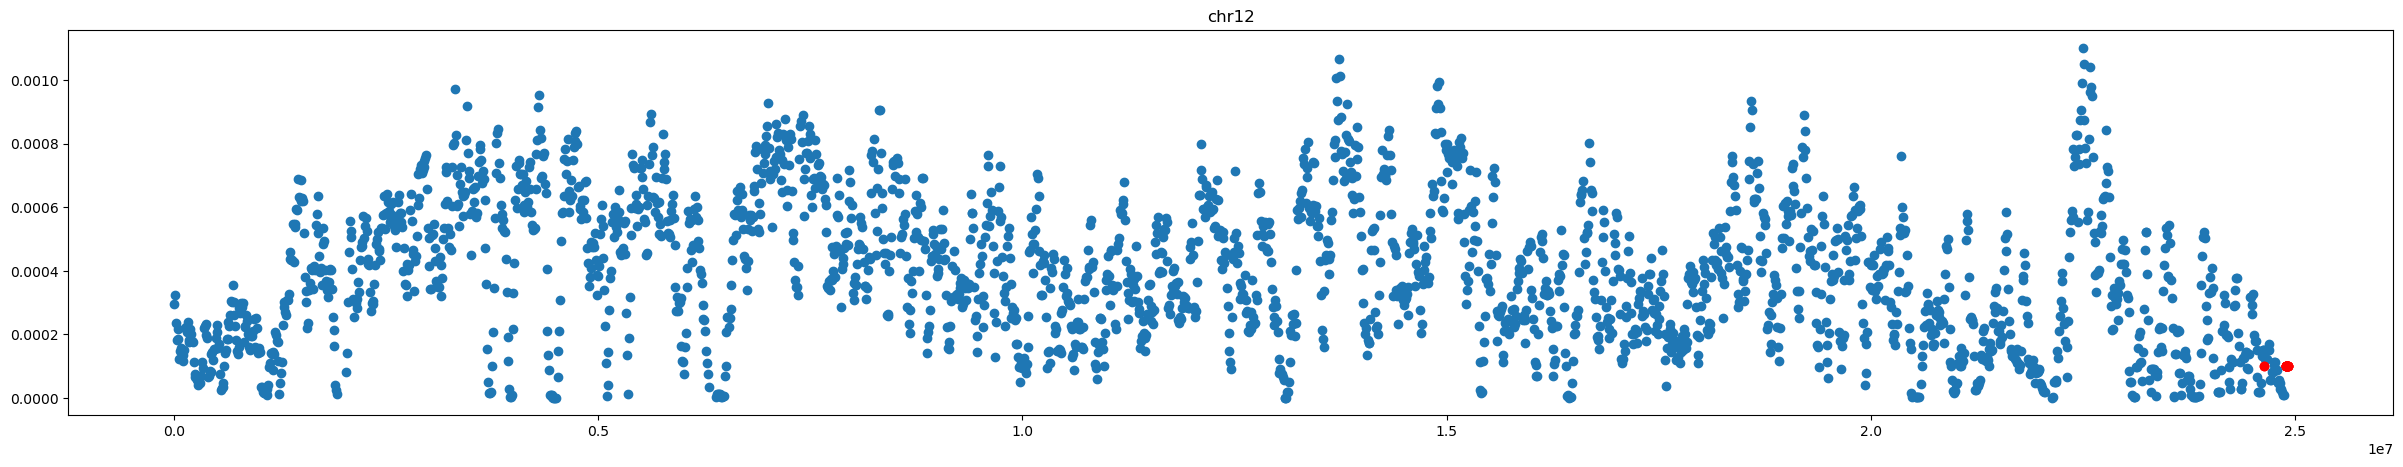

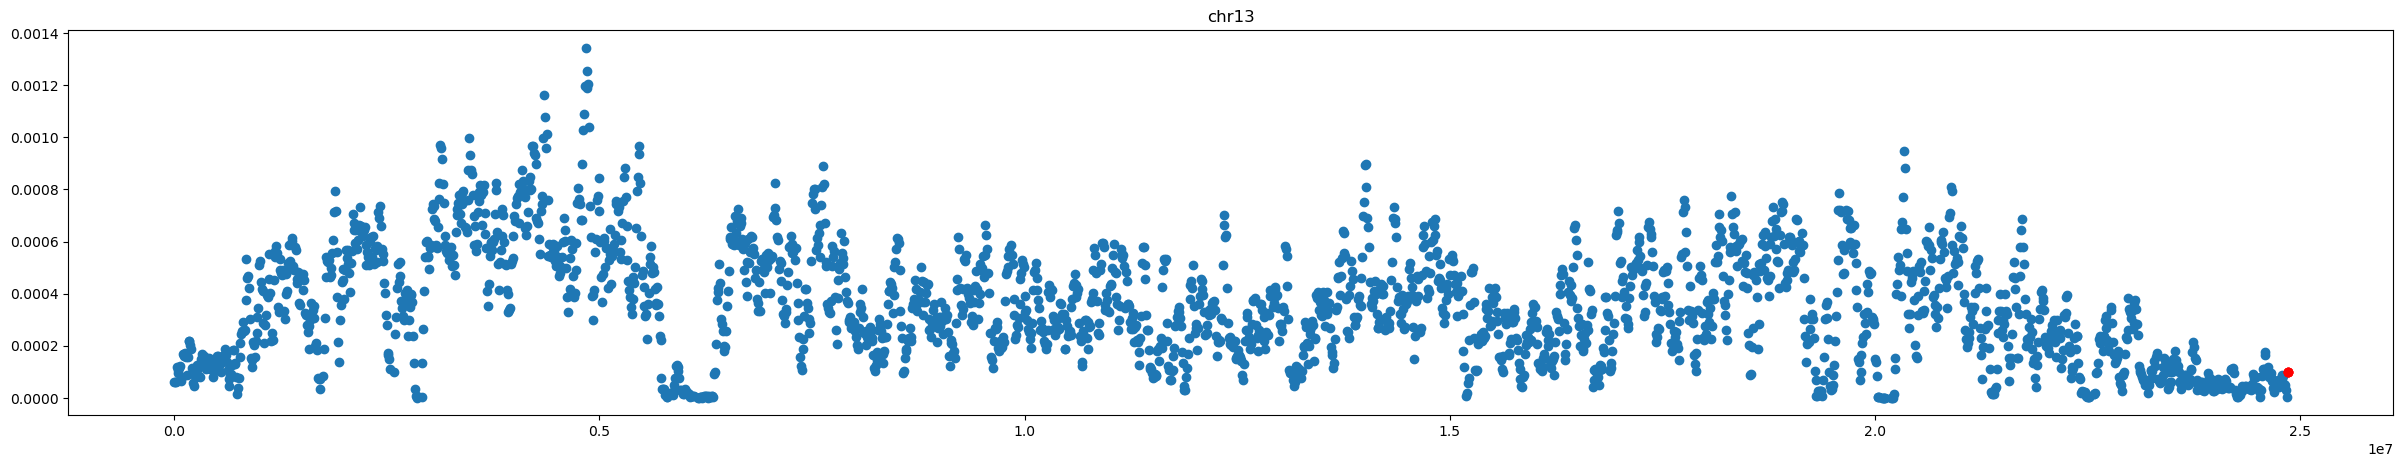

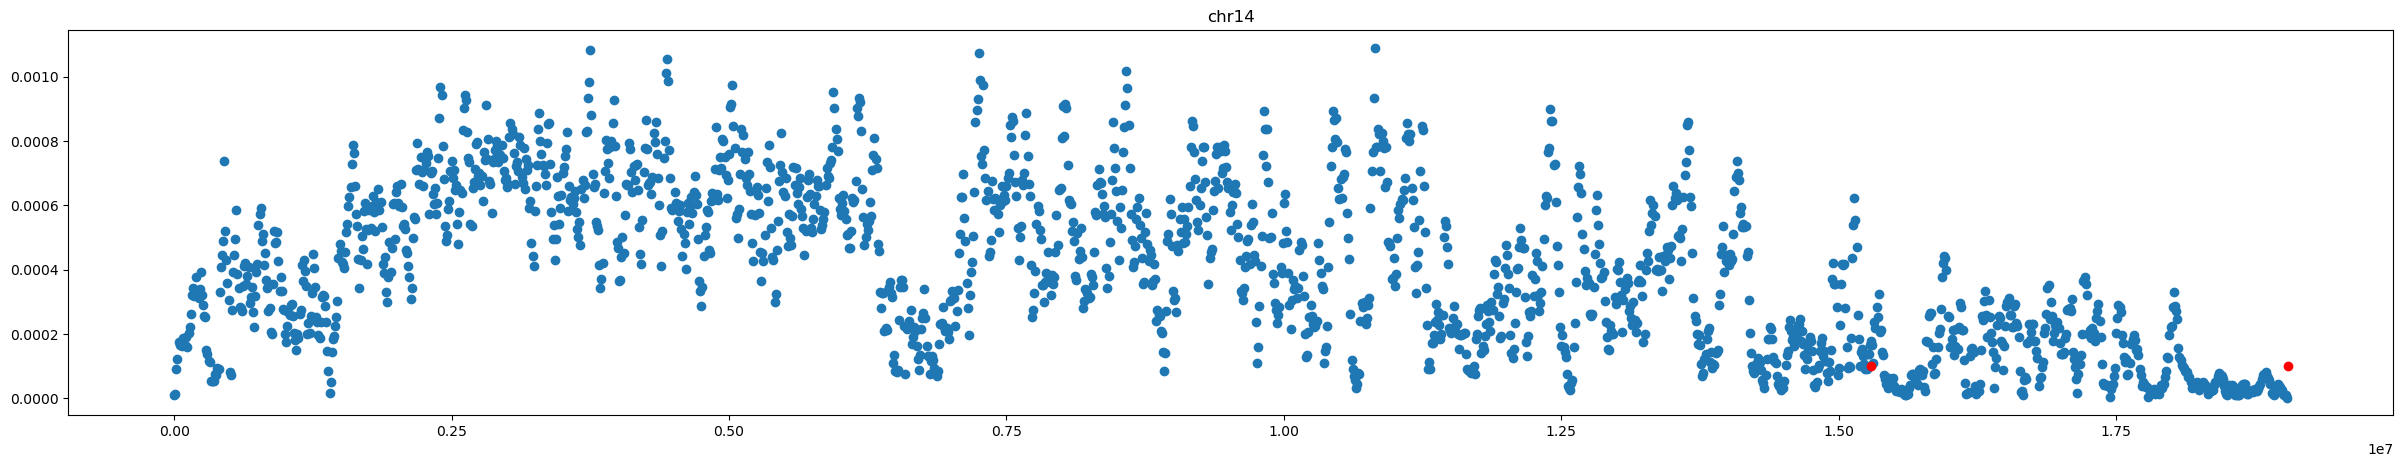

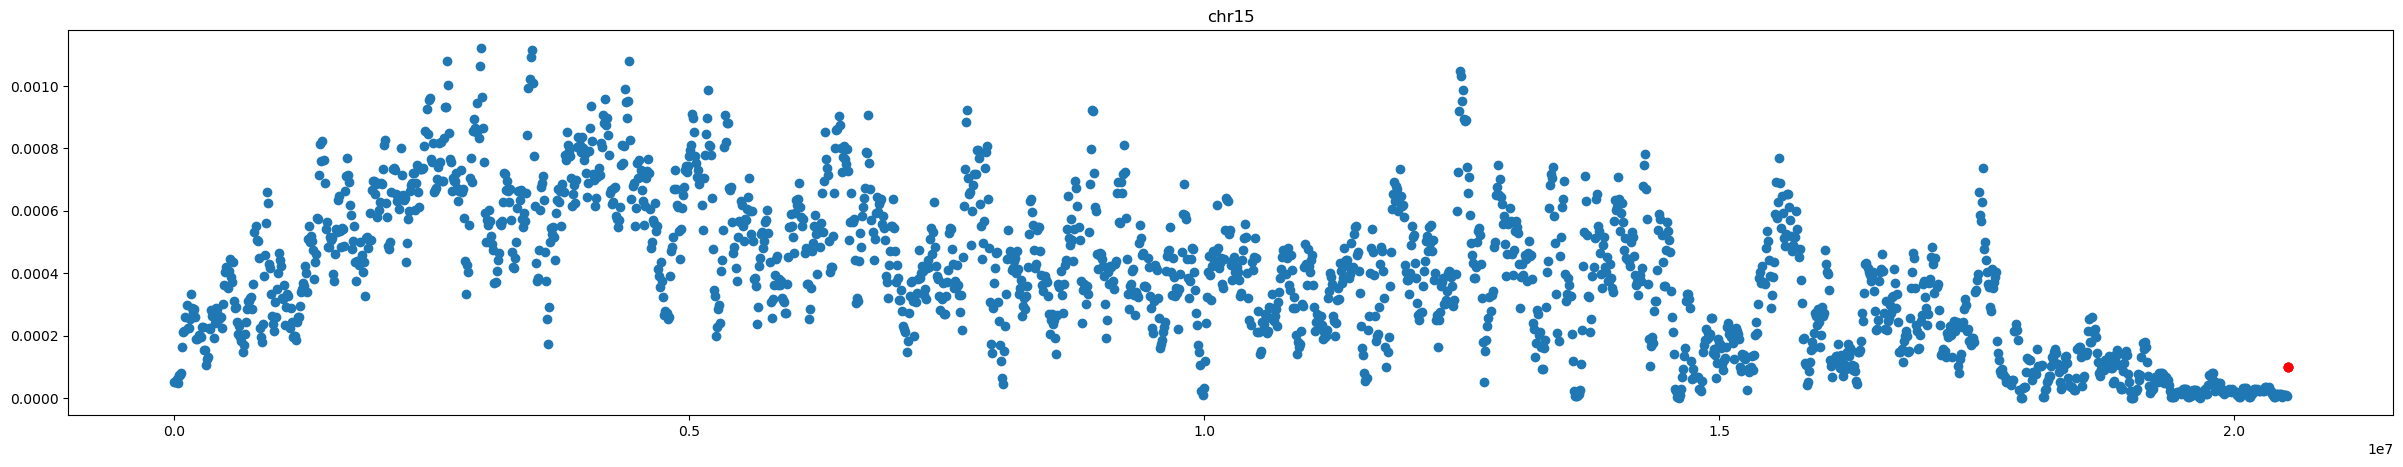

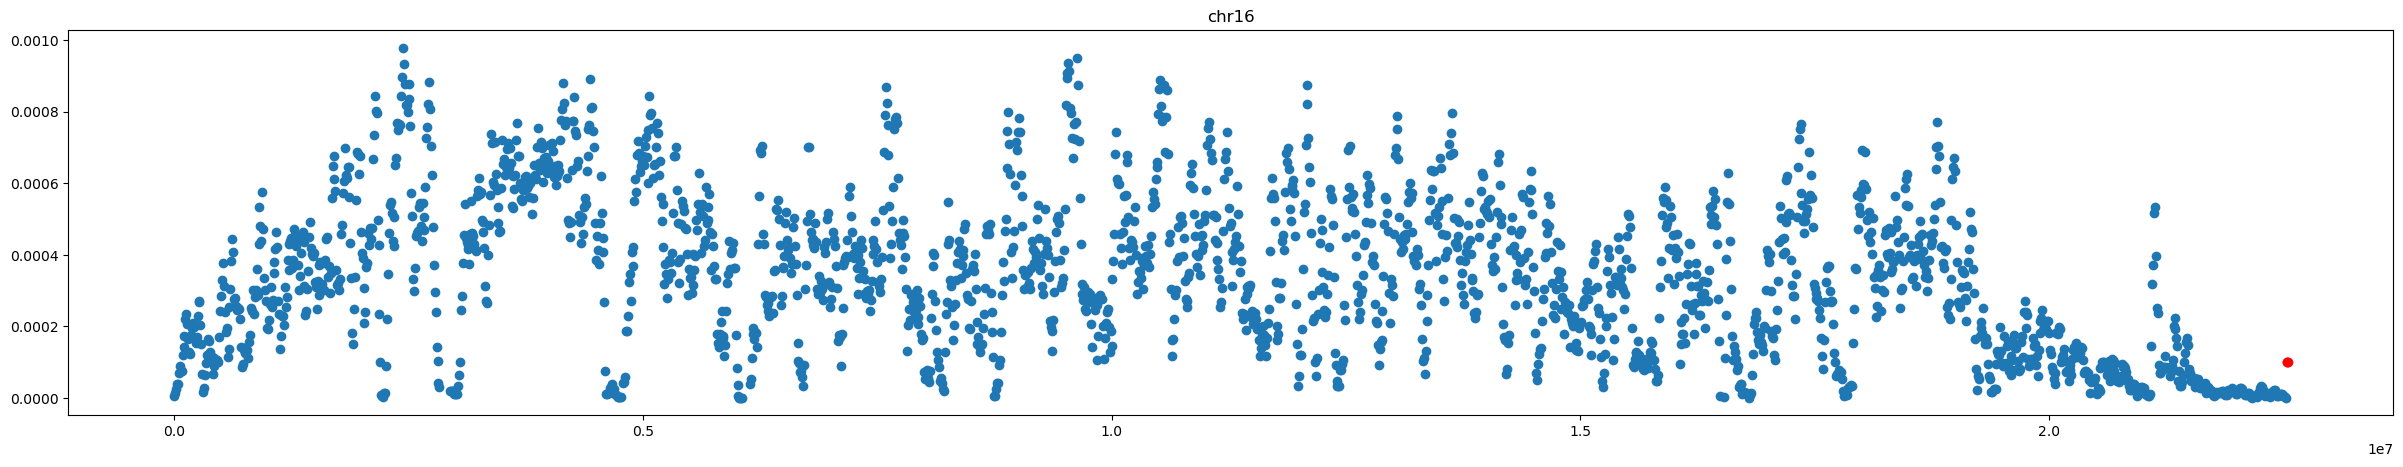

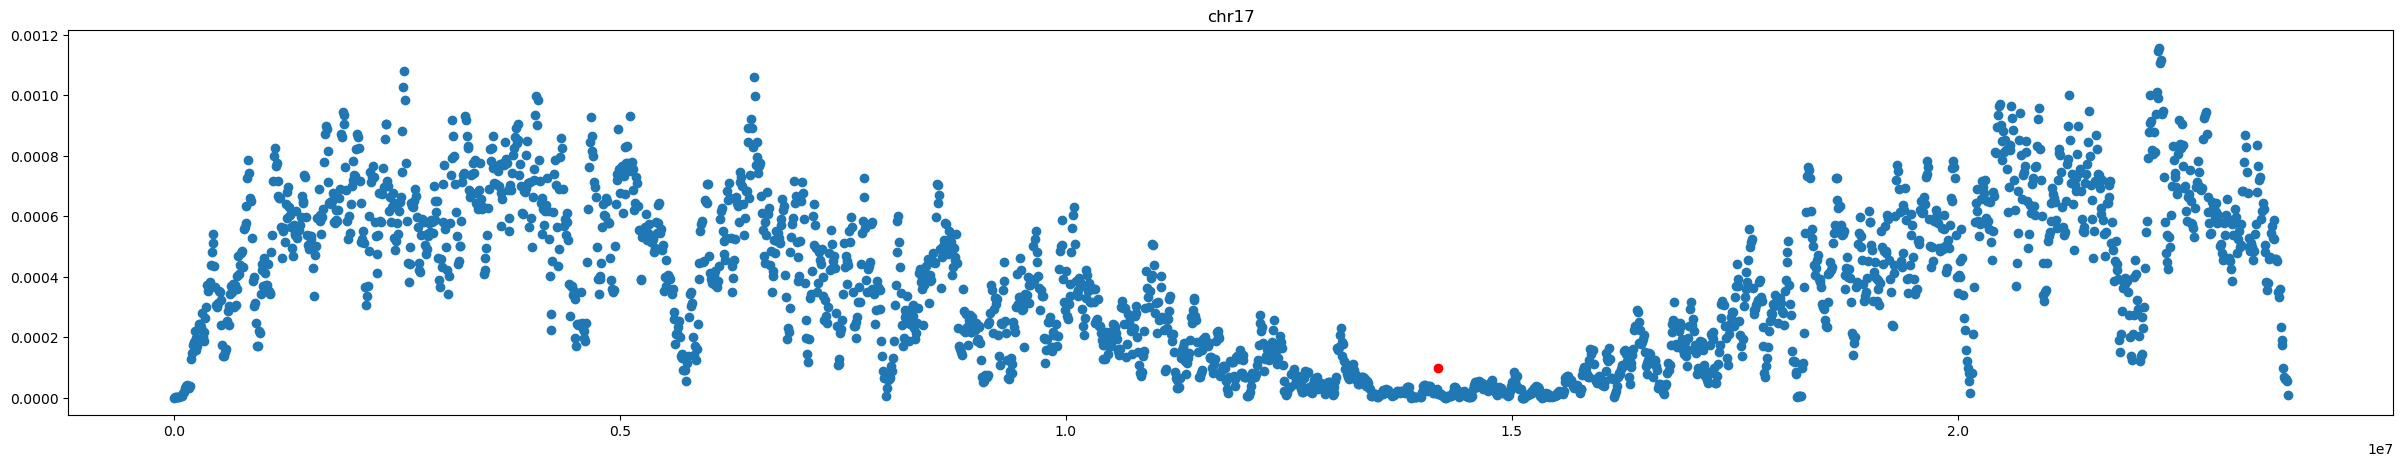

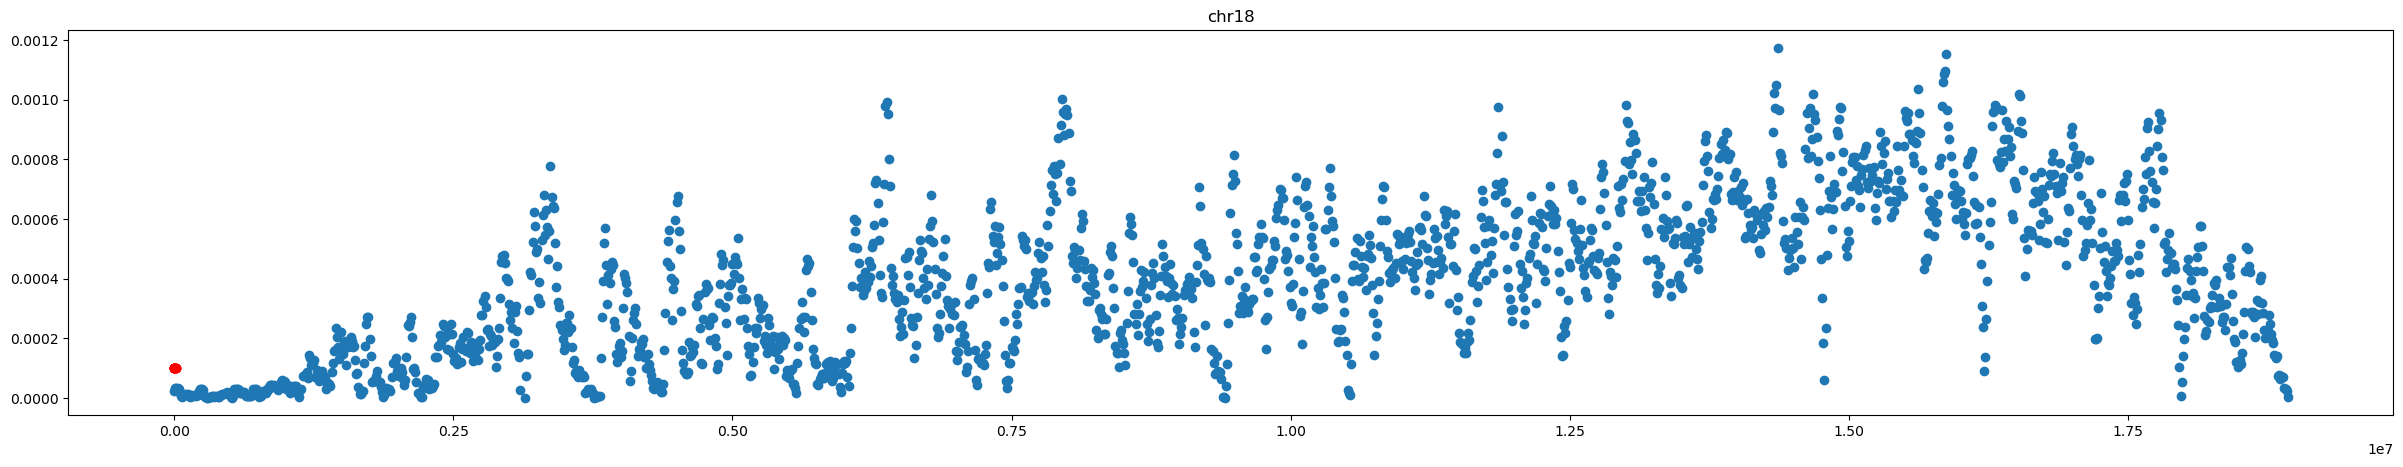

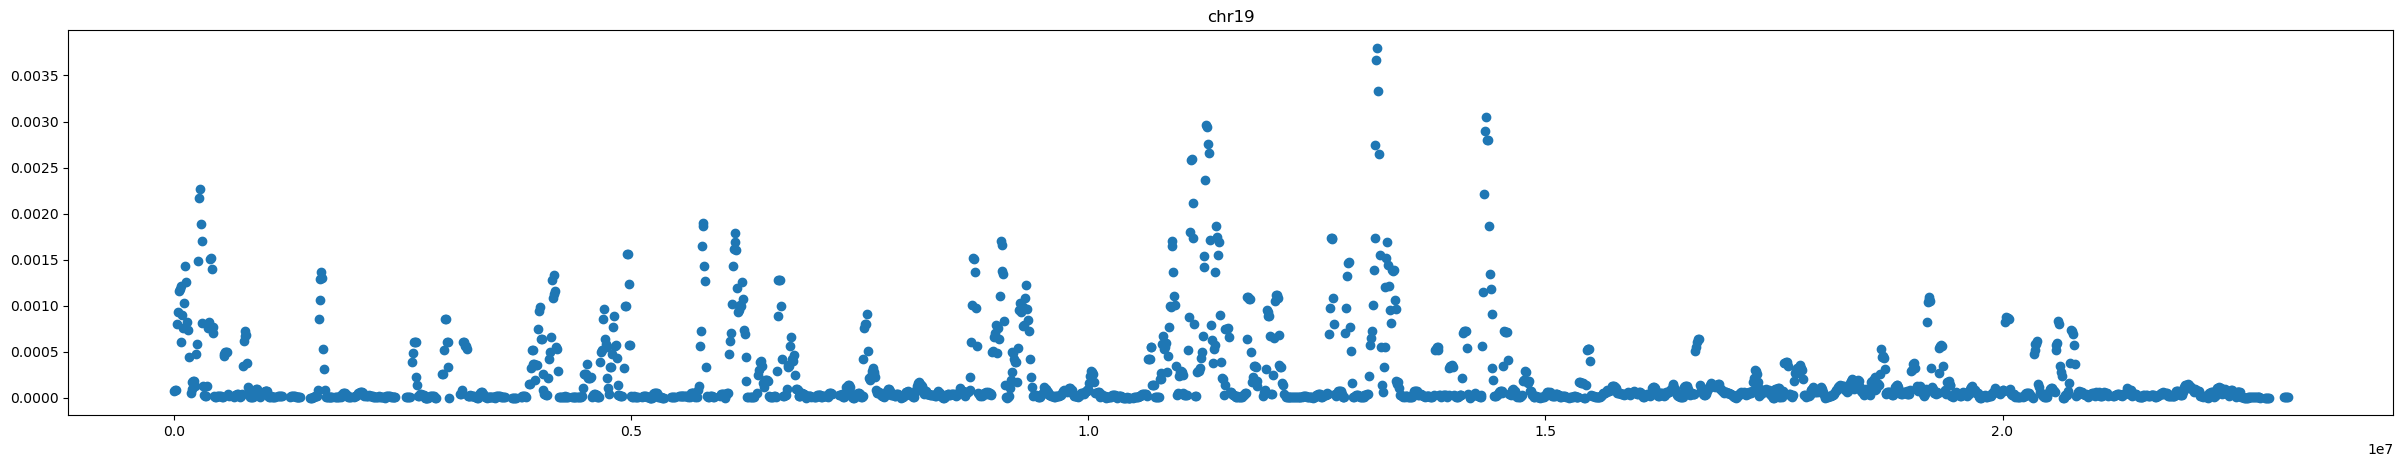

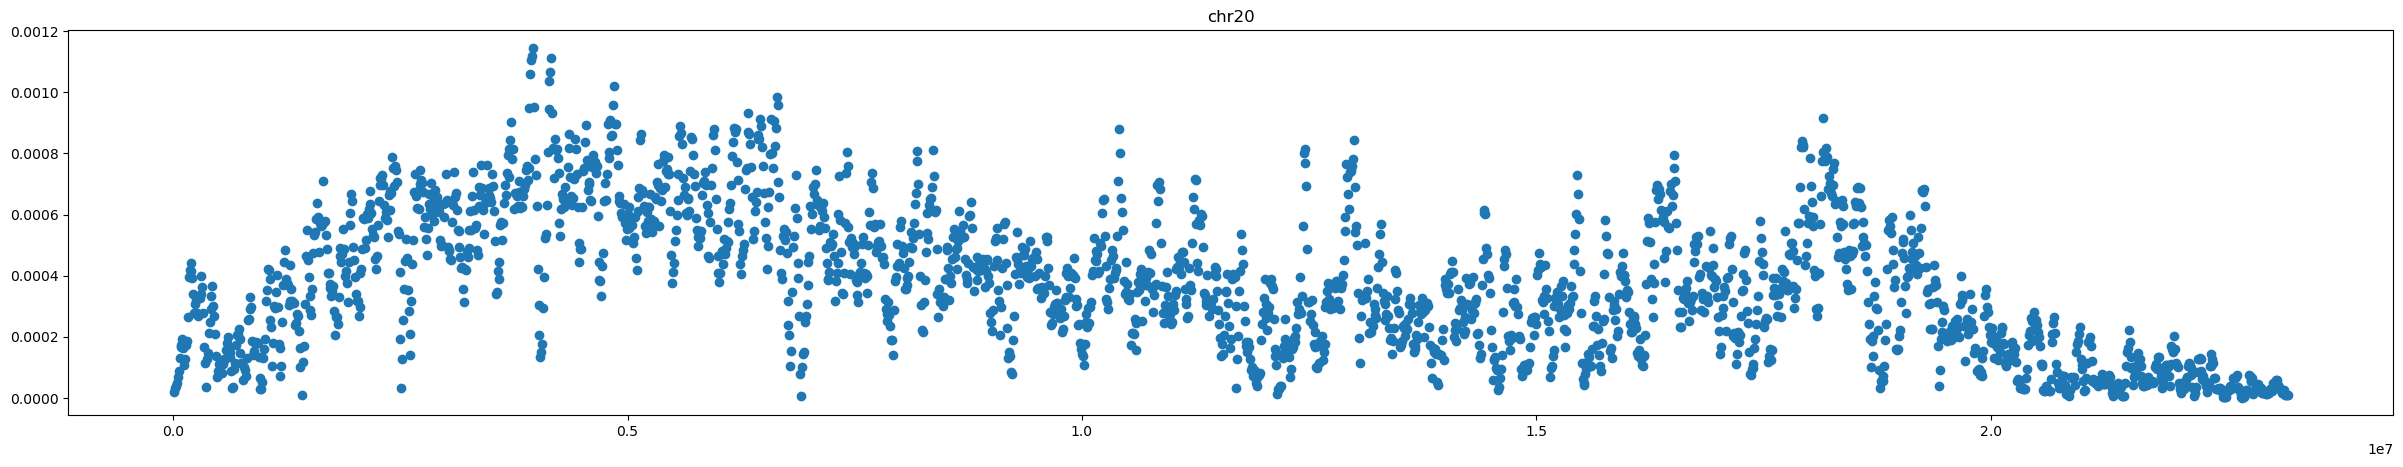

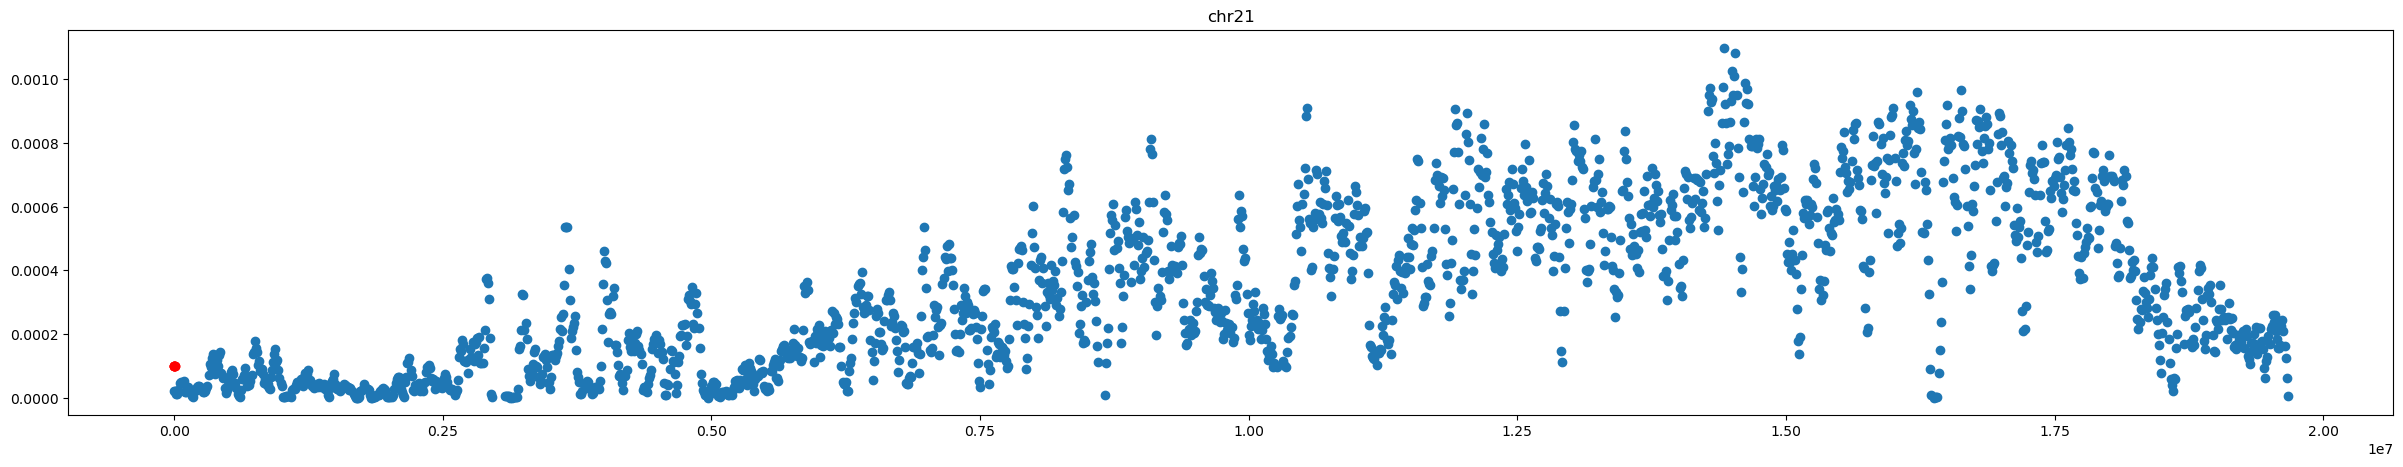

In [111]:
from matplotlib import pyplot as plt

chromosomes = ["chr1", "chr2", "chr3", "chr4", "chr5", "chr6", "chr7", "chr8", "chr9", "chr10", "chr11", "chr12", "chr13", "chr14", "chr15", "chr16", "chr17", "chr18", "chr19", "chr20", "chr21"]

for chrom in chromosomes:
    plt.figure(figsize = (30,5))
    plt.scatter(auto_pi[chrom]["POS"] , auto_pi[chrom]["PI"])
    
    if chrom in cent_hits:
        plt.scatter(cent_hits[chrom], [0.0001]*len(cent_hits[chrom]), c = "red")
    plt.title(chrom)
    plt.show()
    